# Wet vs. Dry Ensemble Members

## Setup

In [123]:
# Import statements
import xarray as xr
import numpy as np
from xskillscore.core.resampling import resample_iterations_idx
from dask.diagnostics.progress import ProgressBar
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from itertools import chain
from scipy.ndimage import gaussian_filter
from dask.delayed import delayed
from dask.base import compute
from metpy.plots import ctables
from matplotlib.animation import FuncAnimation
import matplotlib.patches as patches
from matplotlib.colors import BoundaryNorm

mpl.rcParams["hatch.linewidth"] = 0.2
plt.style.use("dark_background")

In [2]:
# Create function to read in WoFS output
def get_wofs_all(init: int) -> xr.Dataset:
    loaded = xr.open_mfdataset(
        "/mnt/drive2/new-wofs/{init:02d}Z/wofs_ALL*.nc".format(init=init),
        combine="nested",
        concat_dim="time",
        chunks="auto",
    )
    if init < 6:
        loaded["time"] = xr.cftime_range(
            "2021-09-02 {start:02d}:00:00".format(start=init),
            "2021-09-02 {end:02d}:00:00".format(end=init + 6),
            freq="5min",
        )
    elif (init >= 6):
        loaded["time"] = xr.cftime_range(
            "2021-09-01 {start:02d}:00:00".format(start=init),
            "2021-09-02 {end:02d}:00:00".format(end=init-24 + 6),
            freq="5min",
        )
    return(loaded)

# Function to overwrite ne values
def overwrite_ne(da:xr.DataArray|xr.Dataset) -> xr.DataArray|xr.Dataset:
    da["ne"] = range(5)
    return(da)

def smooth(da: xr.DataArray, sigma: int = 3, axes: tuple = (1, 2)) -> xr.DataArray:
    copy = da.copy()  # Make a copy of the DataArray
    copy.values = gaussian_filter(
        da.values, sigma=sigma, axes=axes
    )  # Smooth the values
    return copy  # Return the smoothed DataArray

In [3]:
# Read in 20 - 01 UTC initializations
wofs_all = [get_wofs_all(i) for i in [20,21,22,23,0]]

# Make a new DataArray
init = xr.DataArray(data=["20Z", "21Z", "22Z", "23Z", "00Z"], dims="init")
init = init.assign_coords({"init": init})

In [4]:
lat = wofs_all[0].xlat.isel(time=0).squeeze().drop_vars("time")
lon = wofs_all[0].xlon.isel(time=0).squeeze().drop_vars("time")

# Set up Cartopy projection
proj = ccrs.LambertConformal(
    central_longitude=wofs_all[0].attrs["CEN_LON"],
    central_latitude=wofs_all[0].attrs["CEN_LAT"],
    standard_parallels=(30, 60),
)  # this is the projection that WoFS uses

# Get MetPy precipitation colortable
precip_cmap = ctables.registry.get_colortable("precipitation")
refl_cmap = ctables.registry.get_colortable("NWSReflectivity")

## Create wet and dry ensembles

In [8]:
# Set desired latitude and longitude
# Central Park: 40.7826° N, 73.9656° W
nyc_lat, nyc_lon = 40.7826, -73.9656

# Calculate the Euclidean distance between lat and lon values and the desired point
distance = np.sqrt((lat - nyc_lat) ** 2 + (lon - nyc_lon) ** 2)

# Find where the distance is minimized
nyc_inds = distance.argmin(dim=["NY", "NX"])
lat_ind, lon_ind = int(nyc_inds["NY"]), int(nyc_inds["NX"])

In [9]:
# We are going to sort by the Central Park precip
rain_nyc_0102 = [
    w.rain.isel(lat=lat_ind, lon=lon_ind)
    .sel(time=slice("2021-09-02 01:05:00", "2021-09-02 02:00:00"))
    .sum(dim="time")
    .squeeze()
    for w in wofs_all
]

# Get the indices of the wettest and driest ensemble members
ne_wet = [
    r.ne.where(r > r.quantile(0.75, dim="ne")).dropna(dim="ne").drop_vars("quantile")
    for r in rain_nyc_0102
]
ne_dry = [
    r.ne.where(r < r.quantile(0.25, dim="ne")).dropna(dim="ne").drop_vars("quantile")
    for r in rain_nyc_0102
]

In [10]:
# Select wet and dry members
wofs_wet = [wofs_all[i].sel(ne=ne_wet[i].astype(int)) for i in range(len(wofs_all))]
wofs_dry = [wofs_all[i].sel(ne=ne_dry[i].astype(int)) for i in range(len(wofs_all))]

## 500mb heights

In [11]:
z500_all = (
    xr.concat([w.geo_hgt_500 for w in wofs_all], dim=init)
    .stack(run=("init", "ne"))
    .chunk({"run": -1})
)
z500_wet = (
    xr.concat([overwrite_ne(w.geo_hgt_500) for w in wofs_wet], dim=init)  # type: ignore
    .chunk("auto")
    .stack(run=("init", "ne"))
)
z500_dry = (
    xr.concat([overwrite_ne(w.geo_hgt_500) for w in wofs_dry], dim=init)  # type: ignore
    .chunk("auto")
    .stack(run=("init", "ne"))
)

In [12]:
# Time steps to iterate over
times = ["2021-09-02 00:00:00", "2021-09-02 01:00:00"]
results = []

for time in times:
    z500_chunked = z500_all.sel(time=time).squeeze().chunk({"lat": 25, "lon": 25})
    
    # Resample and compute means
    set1 = resample_iterations_idx(
        z500_chunked,
        1000,
        dim="run",
        replace=False,
        dim_max=25,
    ).mean(dim="run")

    set2 = resample_iterations_idx(
        z500_chunked,
        1000,
        dim="run",
        replace=False,
        dim_max=25,
    ).mean(dim="run")

    # Compute the difference and quantiles
    with ProgressBar():
        result = (set1 - set2).quantile([0.05, 0.95], dim="iteration").compute()
        results.append(result)

# Combine results along the new time dimension
results = xr.concat(results, dim="time")

[########################################] | 100% Completed | 50.01 s
[########################################] | 100% Completed | 49.77 ss


In [13]:
with ProgressBar():
    z500_wet = smooth(
        xr.concat([z500_wet.sel(time=t).squeeze() for t in times], dim="time")
        .mean(dim="run")
        .compute()
    )
    z500_dry = smooth(
        xr.concat([z500_dry.sel(time=t).squeeze() for t in times], dim="time")
        .mean(dim="run")
        .compute()
    )
diff = z500_wet - z500_dry
mask = (diff < results.sel(quantile=0.05).squeeze()) | ( # type: ignore
    diff > results.sel(quantile=0.95).squeeze() # type: ignore
)

[########################################] | 100% Completed | 8.32 sms
[########################################] | 100% Completed | 1.75 sms


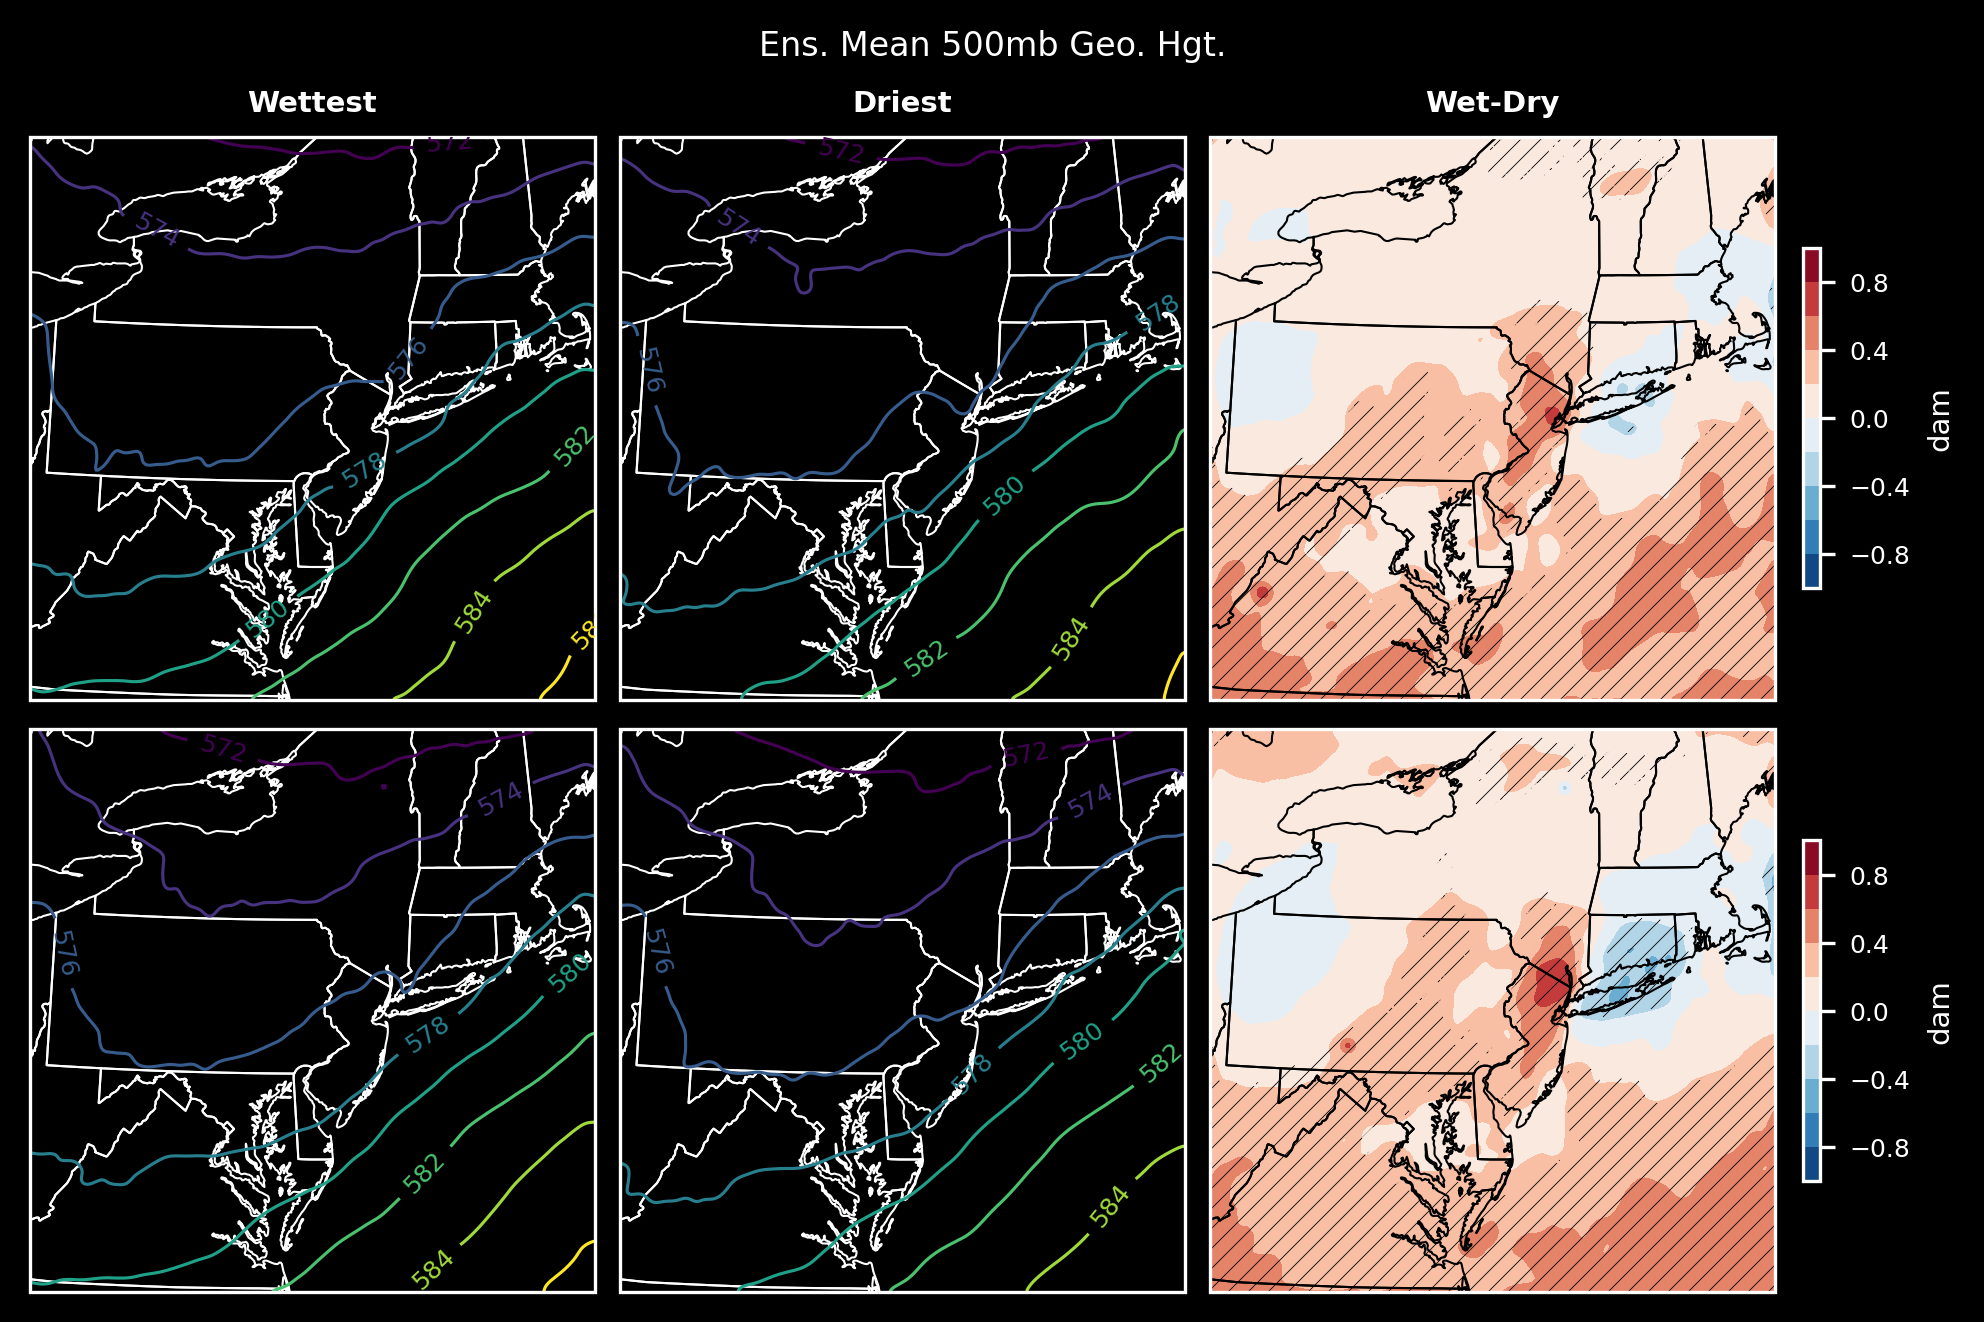

In [14]:
# Plot pw_hourly_wet, dry, and diff
titles = ["Wettest", "Driest", "Wet-Dry"]

values = list(
    chain.from_iterable(
        [
            [z500_wet.sel(time=t), z500_dry.sel(time=t), diff.sel(time=t)]
            for t in times
        ]
    )
)

fig, axes = plt.subplots(
    2,
    3,
    subplot_kw=dict(projection=proj),
    dpi=300,
    layout="constrained",
    figsize=(6.5, 4.3),
)

for i, ax in enumerate(axes.flatten()):
    if i not in [2, 5]:
        c = ax.contour(
            lon,
            lat,
            values[i].squeeze() / 10,
            transform=ccrs.PlateCarree(),
            levels=np.arange(572, 587, 2),
            linewidths=0.75,
        )
        c.clabel(inline=True, fontsize=6, fmt="%d")
        c.axes.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="white")
    else:
        c = ax.contourf(
            lon,
            lat,
            values[i].squeeze() / 10,
            transform=ccrs.PlateCarree(),
            levels=np.arange(-1,1.1,0.2),
            cmap="RdBu_r",
        )
        # Add hatches in masked area
        ax.contourf(
            lon,
            lat,
            mask.sel(time=values[i].time).squeeze(),
            transform=ccrs.PlateCarree(),
            levels=[0, 0.5, 1],
            hatches=["", "/////"],
            colors="none",
        )
        c.axes.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="black")

        cbar = plt.colorbar(c,ax=ax,shrink=0.6)
        cbar.ax.tick_params(labelsize=6)
    if(i in [2,5]):
        cbar.set_label("dam",fontsize=7)

    if(i<3):
        ax.set_title(titles[i],fontsize=7, fontweight="bold")

plt.suptitle("Ens. Mean 500mb Geo. Hgt.",fontsize=8)
plt.show()

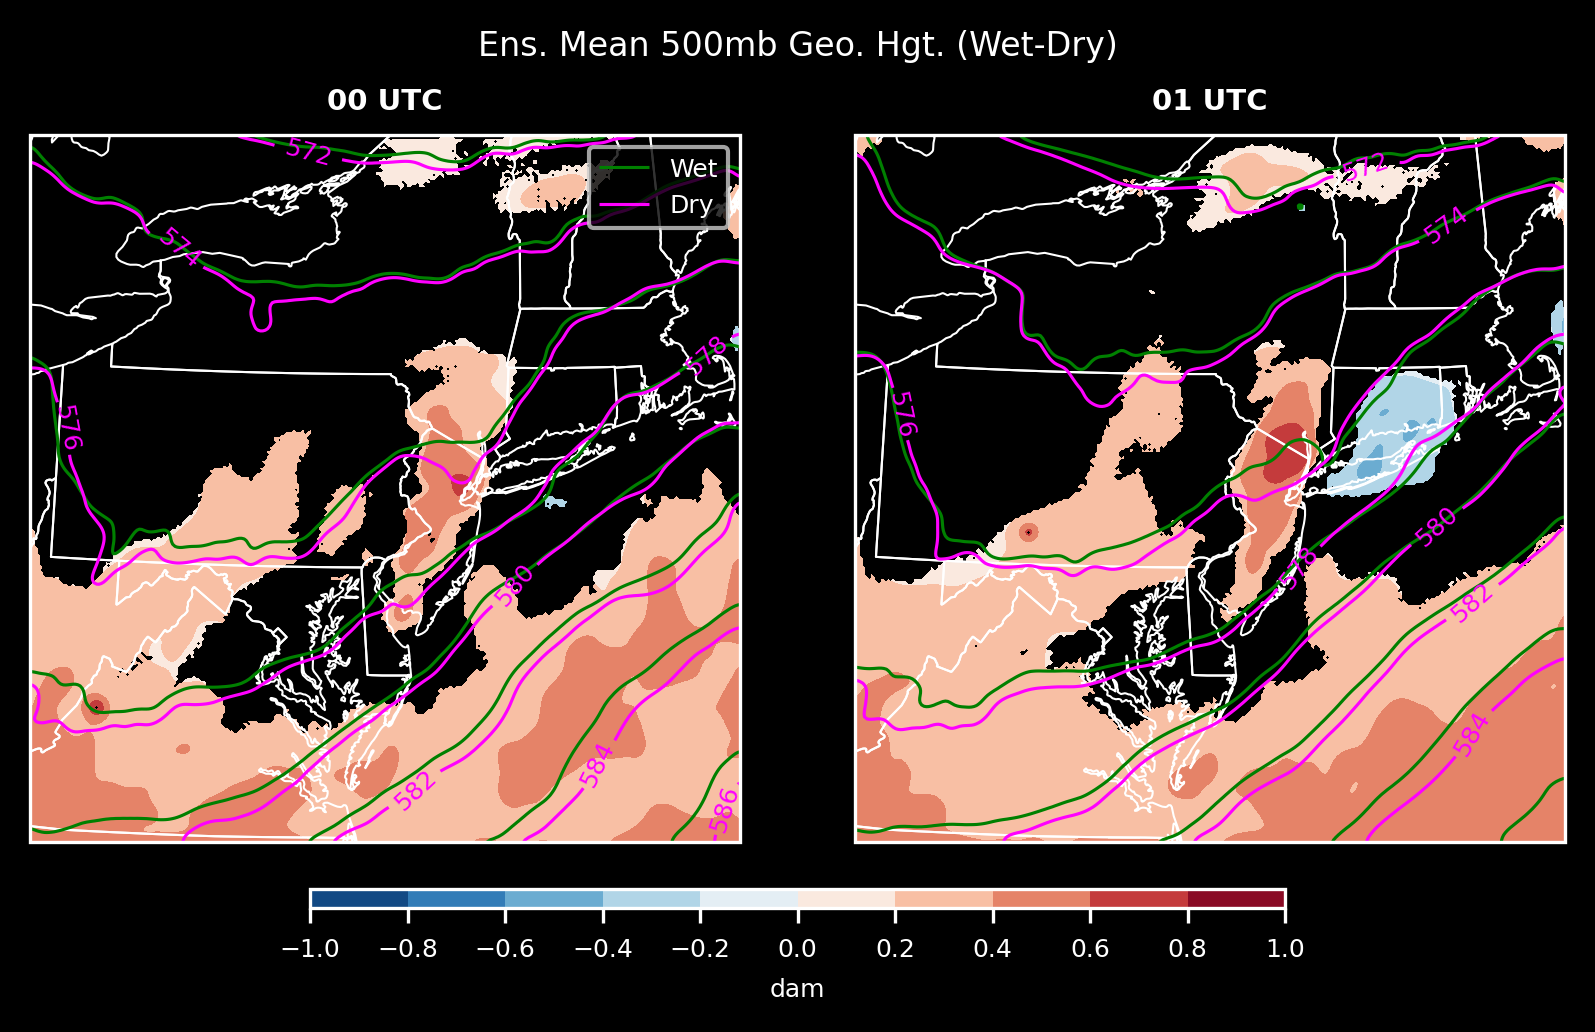

In [15]:
# Create a plot of the difference in z500 wet & dry,
# then overlay z500 wet in green lines and z500 dry in magenta lines

titles = ["00 UTC", "01 UTC"]
times = ["2021-09-02 00:00:00", "2021-09-02 01:00:00"]
diffs = [diff.sel(time=t).squeeze() for t in times]
z500_wets = [z500_wet.sel(time=t).squeeze() for t in times]
z500_drys = [z500_dry.sel(time=t).squeeze() for t in times]
masks = [mask.sel(time=t).squeeze() for t in times]
diff_levs = np.arange(-1, 1.1, 0.2)
z500_levs = range(572,587,2)
labels = ["Wet","Dry"]

# Make a figure with 2 by 1 subplots
fig, axes = plt.subplots(
    1,
    2,
    figsize=(5.5, 3.3),
    dpi=300,
    layout="constrained",
    subplot_kw=dict(projection=proj),
)

# iterate through axes and plot
for i, ax in enumerate(axes.flat): # type: ignore
    # Plot the difference, but only where significant
    cf = ax.contourf(
        lon,
        lat,
        diffs[i].where(masks[i]) / 10,
        transform=ccrs.PlateCarree(),
        levels=diff_levs,
        cmap="RdBu_r",
    )

    # Add state lines
    cf.axes.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="white")

    # Overlay z500_wet and z500_dry contours
    c1 = ax.contour(
        lon,
        lat,
        z500_wets[i] / 10,
        transform=ccrs.PlateCarree(),
        levels=z500_levs,
        linewidths=0.75,
        colors="green",
    )

    c2 = ax.contour(
        lon,
        lat,
        z500_drys[i] / 10,
        transform=ccrs.PlateCarree(),
        levels=z500_levs,
        linewidths=0.75,
        colors="magenta",
    )
    c2.clabel(inline=True, fontsize=6, fmt="%d")

    # set title
    ax.set_title(titles[i],fontsize=7, fontweight="bold")

    if (i==0): # first plot only
        h1,_ = c1.legend_elements()
        h2,_ = c2.legend_elements()
        ax.legend([h1[0],h2[0]],labels,fontsize=6)


# Add one colorbar to entire plot on bottom horizontal
cbar = fig.colorbar(cf,ax=axes,shrink=0.6,aspect=50, orientation= "horizontal",)
cbar.ax.tick_params(labelsize=6)
cbar.set_label("dam",fontsize=6)
cbar.set_ticks(diff_levs)

# Set suptitle
plt.suptitle("Ens. Mean 500mb Geo. Hgt. (Wet-Dry)",fontsize=8)

# show
plt.show()



### 500mb geostrophic winds

In [62]:
def calculate_geostrophic_wind(z500: xr.DataArray, lat: xr.DataArray) -> tuple[xr.DataArray, xr.DataArray]:
    # Constants
    g = 9.81  # acceleration due to gravity (m/s²)
    Omega = 7.2921e-5  # angular velocity of the Earth (rad/s)

    # Calculate f
    f = 2 * Omega * np.sin(np.deg2rad(lat))

    # Copy input da
    z500_copy = z500.copy()

    # Turn lat/lon coordinates into y,x in meters
    z500_copy["lat"] = z500_copy.lat*3000
    z500_copy["lon"] = z500_copy.lon*3000

    # Calculate gradient
    dPhidy = z500_copy.differentiate(coord="lat",edge_order=2)
    dPhidx = z500_copy.differentiate(coord="lon",edge_order=2)

    # Calculate geostrophic wind components
    u_g = (-g/f.values)*dPhidy
    v_g = (g/f.values)*dPhidx

    # Create new DataArrays
    u_g["lat"],u_g["lon"] = z500.lat,z500.lon
    v_g["lat"],v_g["lon"] = z500.lat,z500.lon

    return(u_g,v_g)

In [78]:
ug500_wet,vg500_wet = calculate_geostrophic_wind(z500_wet,lat)
ug500_dry,vg500_dry = calculate_geostrophic_wind(z500_dry,lat)
ug500_diff,vg500_diff = ug500_wet-ug500_dry,vg500_wet-vg500_dry

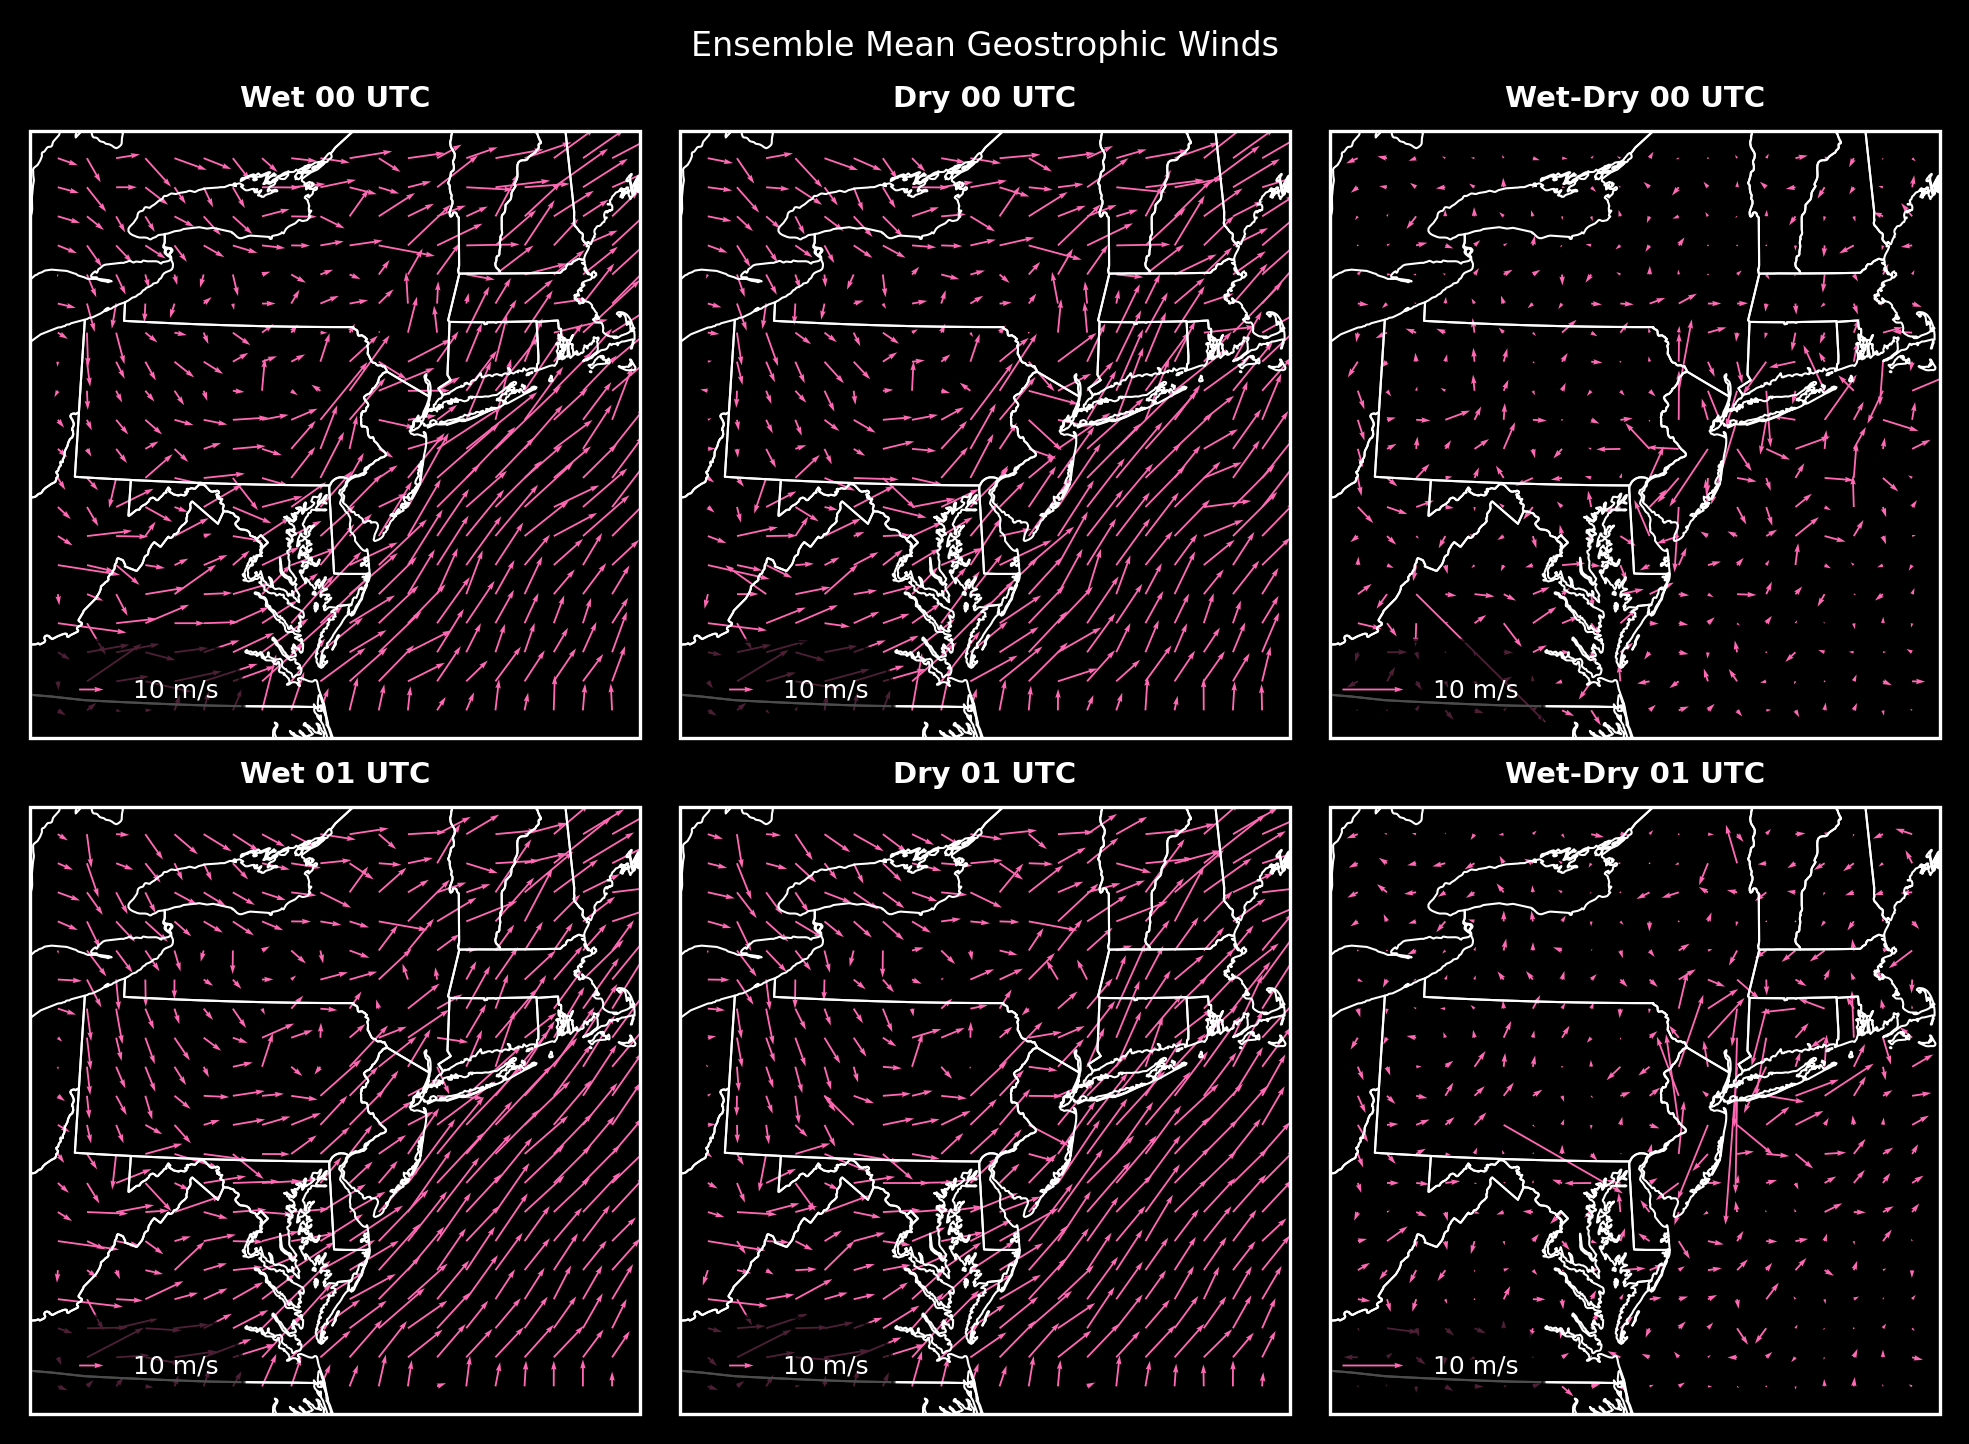

In [66]:
# Titles
titles = ["Wet 00 UTC","Dry 00 UTC","Wet-Dry 00 UTC",
          "Wet 01 UTC","Dry 01 UTC","Wet-Dry 01 UTC"]

# Take every 10th lat and lon values
lon_quiv = lon.values[::15,::15]
lat_quiv = lat.values[::15,::15]
scales = [250,250,100,250,250,100]

# Isolate geostrophic wind vectors, taking every 10th
geo_winds = [
    [
        ug500_wet.isel(time=0).squeeze().values[::15, ::15],
        vg500_wet.isel(time=0).squeeze().values[::15, ::15],
    ],
    [
        ug500_dry.isel(time=0).squeeze().values[::15, ::15],
        vg500_dry.isel(time=0).squeeze().values[::15, ::15],
    ],
    [
        ug500_diff.isel(time=0).squeeze().values[::15, ::15],
        vg500_diff.isel(time=0).squeeze().values[::15, ::15],
    ],
    [
        ug500_wet.isel(time=1).squeeze().values[::15, ::15],
        vg500_wet.isel(time=1).squeeze().values[::15, ::15],
    ],
    [
        ug500_dry.isel(time=1).squeeze().values[::15, ::15],
        vg500_dry.isel(time=1).squeeze().values[::15, ::15],
    ],
    [
        ug500_diff.isel(time=1).squeeze().values[::15, ::15],
        vg500_diff.isel(time=1).squeeze().values[::15, ::15],
    ]
]

fig, axes = plt.subplots(
    2,
    3,
    figsize=(6.5, 4.7),
    dpi=300,
    layout="constrained",
    subplot_kw=dict(projection=proj),
)

for i,ax in enumerate(axes.flat): # type: ignore
    q = ax.quiver(
        lon_quiv,
        lat_quiv,
        geo_winds[i][0],
        geo_winds[i][1],
        transform=ccrs.PlateCarree(),
        scale=scales[i],
        color="hotpink",
    )

    # add state boundaries
    ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="white")

    # Add title
    ax.set_title(titles[i],fontsize=7,fontweight="bold")

    # Add a reference vector with a background rectangle
    bbox = patches.FancyBboxPatch((0.1, 0.05), 0.15, 0.01,
                                  boxstyle="round,pad=0.1",
                                  transform=ax.transAxes,
                                  color='black',
                                  alpha=0.7,
                                  zorder=2)
    ax.add_patch(bbox)
    qk = ax.quiverkey(q, 0.12, 0.08, 10, '10 m/s', labelpos='E', coordinates='axes', fontproperties={'size': 6}, color='hotpink')
    qk.set_zorder(3)

# Set suptitle
plt.suptitle("Ensemble Mean Geostrophic Winds",fontsize=8)

plt.show()

## 500mb Winds

In [47]:
wnd_500_wet = (
    xr.concat([overwrite_ne(xr.merge([w.U_500, w.V_500])) for w in wofs_wet], dim=init)  # type: ignore
    .chunk("auto")
    .stack(run=("init", "ne"))
)
wnd_500_dry = (
    xr.concat([overwrite_ne(xr.merge([w.U_500, w.V_500])) for w in wofs_dry], dim=init)  # type: ignore
    .chunk("auto")
    .stack(run=("init", "ne"))
)


In [67]:
with ProgressBar():
    wnd_500_wet = (
        xr.concat([wnd_500_wet.sel(time=t).squeeze() for t in times], dim="time")
        .mean(dim="run")
        .compute()
    )
    wnd_500_dry = (
        xr.concat([wnd_500_dry.sel(time=t).squeeze() for t in times], dim="time")
        .mean(dim="run")
        .compute()
    )

wnd_500_diff = wnd_500_wet - wnd_500_dry

ValueError: Dimensions ('run',) not found in data dimensions ('time', 'lat', 'lon')

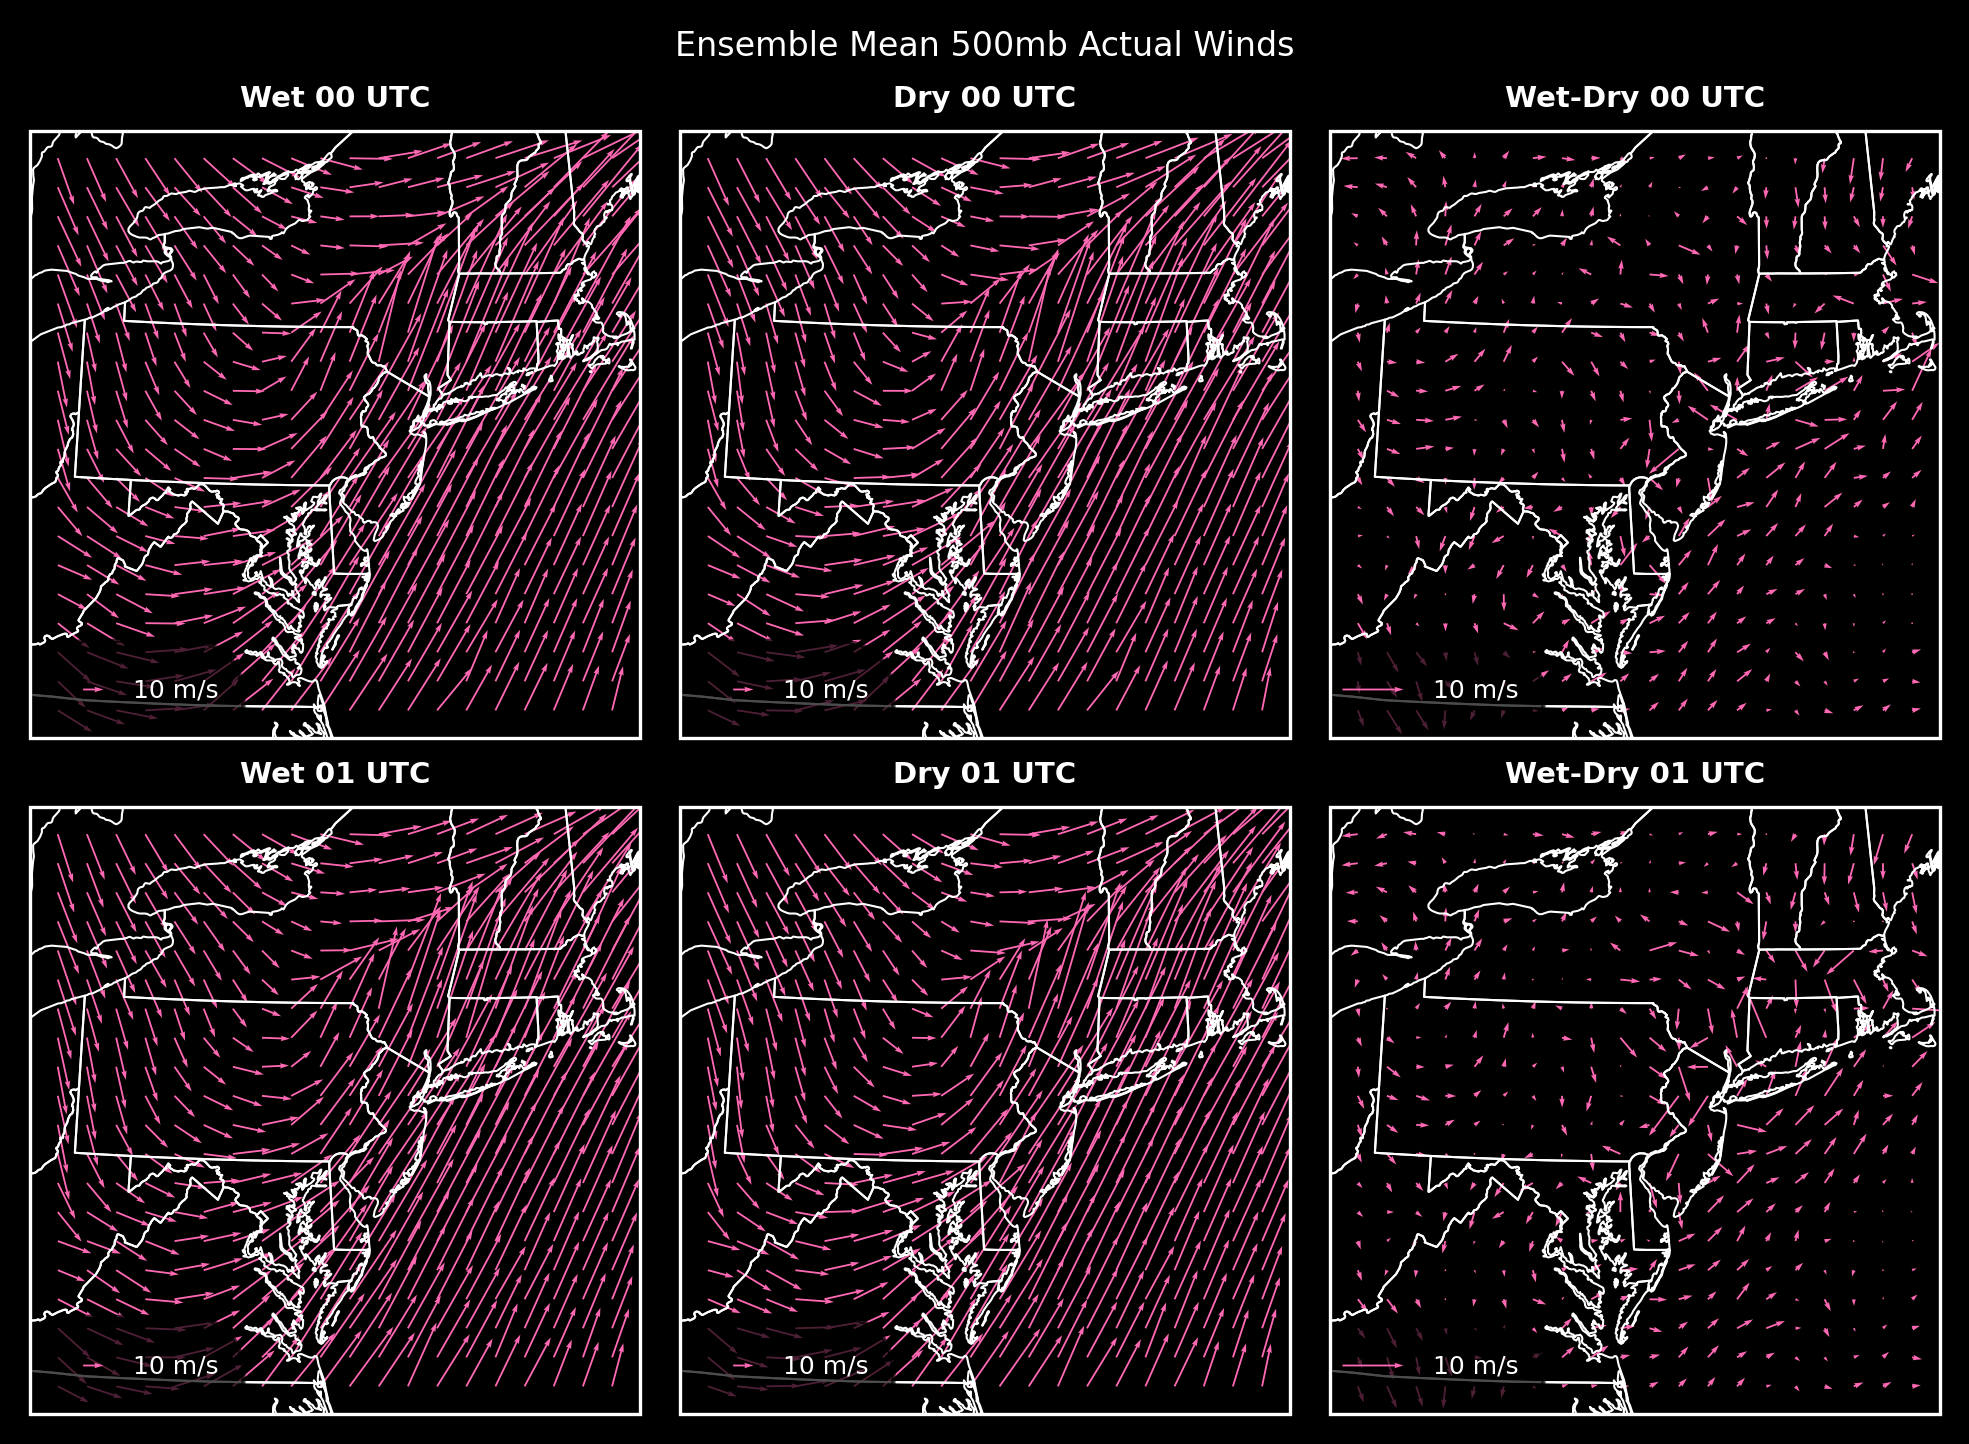

In [73]:
# Titles
titles = ["Wet 00 UTC","Dry 00 UTC","Wet-Dry 00 UTC",
          "Wet 01 UTC","Dry 01 UTC","Wet-Dry 01 UTC"]

# Take every 10th lat and lon values
lon_quiv = lon.values[::15,::15]
lat_quiv = lat.values[::15,::15]
scales = [300,300,100,300,300,100]

# Isolate wind vectors
winds = [data.isel(time=t).squeeze().isel(lat=slice(None,None,15),lon=slice(None,None,15))
         for t in range(2)
         for data in [wnd_500_wet, wnd_500_dry, wnd_500_diff]]


fig, axes = plt.subplots(
    2,
    3,
    figsize=(6.5, 4.7),
    dpi=300,
    layout="constrained",
    subplot_kw=dict(projection=proj),
)

for i,ax in enumerate(axes.flat): # type: ignore
    q = ax.quiver(
        lon_quiv,
        lat_quiv,
        winds[i].U_500.values,
        winds[i].V_500.values,
        transform=ccrs.PlateCarree(),
        scale=scales[i],
        color="hotpink",
    )

    # add state boundaries
    ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="white")

    # Add title
    ax.set_title(titles[i],fontsize=7,fontweight="bold")

    # Add a reference vector with a background rectangle
    bbox = patches.FancyBboxPatch((0.1, 0.05), 0.15, 0.01,
                                  boxstyle="round,pad=0.1",
                                  transform=ax.transAxes,
                                  color='black',
                                  alpha=0.7,
                                  zorder=2)
    ax.add_patch(bbox)
    qk = ax.quiverkey(q, 0.12, 0.08, 10, '10 m/s', labelpos='E', coordinates='axes', fontproperties={'size': 6}, color='hotpink')
    qk.set_zorder(3)

# Set suptitle
plt.suptitle("Ensemble Mean 500mb Actual Winds",fontsize=8)

plt.show()

## Let's add in the other geostrophic winds

In [80]:
z700_wet = (
    xr.concat([overwrite_ne(w.geo_hgt_700) for w in wofs_wet], dim=init)  # type: ignore
    .chunk("auto")
    .stack(run=("init", "ne"))
)
z700_dry = (
    xr.concat([overwrite_ne(w.geo_hgt_700) for w in wofs_dry], dim=init)  # type: ignore
    .chunk("auto")
    .stack(run=("init", "ne"))
)
z850_wet = (
    xr.concat([overwrite_ne(w.geo_hgt_850) for w in wofs_wet], dim=init)  # type: ignore
    .chunk("auto")
    .stack(run=("init", "ne"))
)
z850_dry = (
    xr.concat([overwrite_ne(w.geo_hgt_850) for w in wofs_dry], dim=init)  # type: ignore
    .chunk("auto")
    .stack(run=("init", "ne"))
)

In [82]:
with ProgressBar():
    z700_wet = smooth(
        xr.concat([z700_wet.sel(time=t).squeeze() for t in times], dim="time")
        .mean(dim="run")
        .compute()
    )
    z700_dry = smooth(
        xr.concat([z700_dry.sel(time=t).squeeze() for t in times], dim="time")
        .mean(dim="run")
        .compute()
    )
    z850_wet = smooth(
        xr.concat([z850_wet.sel(time=t).squeeze() for t in times], dim="time")
        .mean(dim="run")
        .compute()
    )
    z850_dry = smooth(
        xr.concat([z850_dry.sel(time=t).squeeze() for t in times], dim="time")
        .mean(dim="run")
        .compute()
    )
diff_700 = z700_wet - z700_dry
diff_850 = z850_wet - z850_dry

[########################################] | 100% Completed | 4.17 sms
[########################################] | 100% Completed | 1.04 sms


In [83]:
ug700_wet,vg700_wet = calculate_geostrophic_wind(z700_wet,lat)
ug700_dry,vg700_dry = calculate_geostrophic_wind(z700_dry,lat)
ug700_diff,vg700_diff = ug700_wet-ug700_dry,vg700_wet-vg700_dry

ug850_wet,vg850_wet = calculate_geostrophic_wind(z850_wet,lat)
ug850_dry,vg850_dry = calculate_geostrophic_wind(z850_dry,lat)
ug850_diff,vg850_diff = ug850_wet-ug850_dry,vg850_wet-vg850_dry

In [97]:
# Calculate the layer average geostrophic wind
ug_avg_wet = (
    (ug700_wet + ug850_wet) * (150 / 2) + (ug700_wet + ug500_wet) * (200 / 2)
) * (1 / 350)
ug_avg_dry = (
    (ug700_dry + ug850_dry) * (150 / 2) + (ug700_dry + ug500_dry) * (200 / 2)
) * (1 / 350)

vg_avg_wet = (
    (vg700_wet + vg850_wet) * (150 / 2) + (vg700_wet + vg500_wet) * (200 / 2)
) * (1 / 350)
vg_avg_dry = (
    (vg700_dry + vg850_dry) * (150 / 2) + (vg700_dry + vg500_dry) * (200 / 2)
) * (1 / 350)

ug_avg_diff = ug_avg_wet - ug_avg_dry
vg_avg_diff = vg_avg_wet - vg_avg_dry


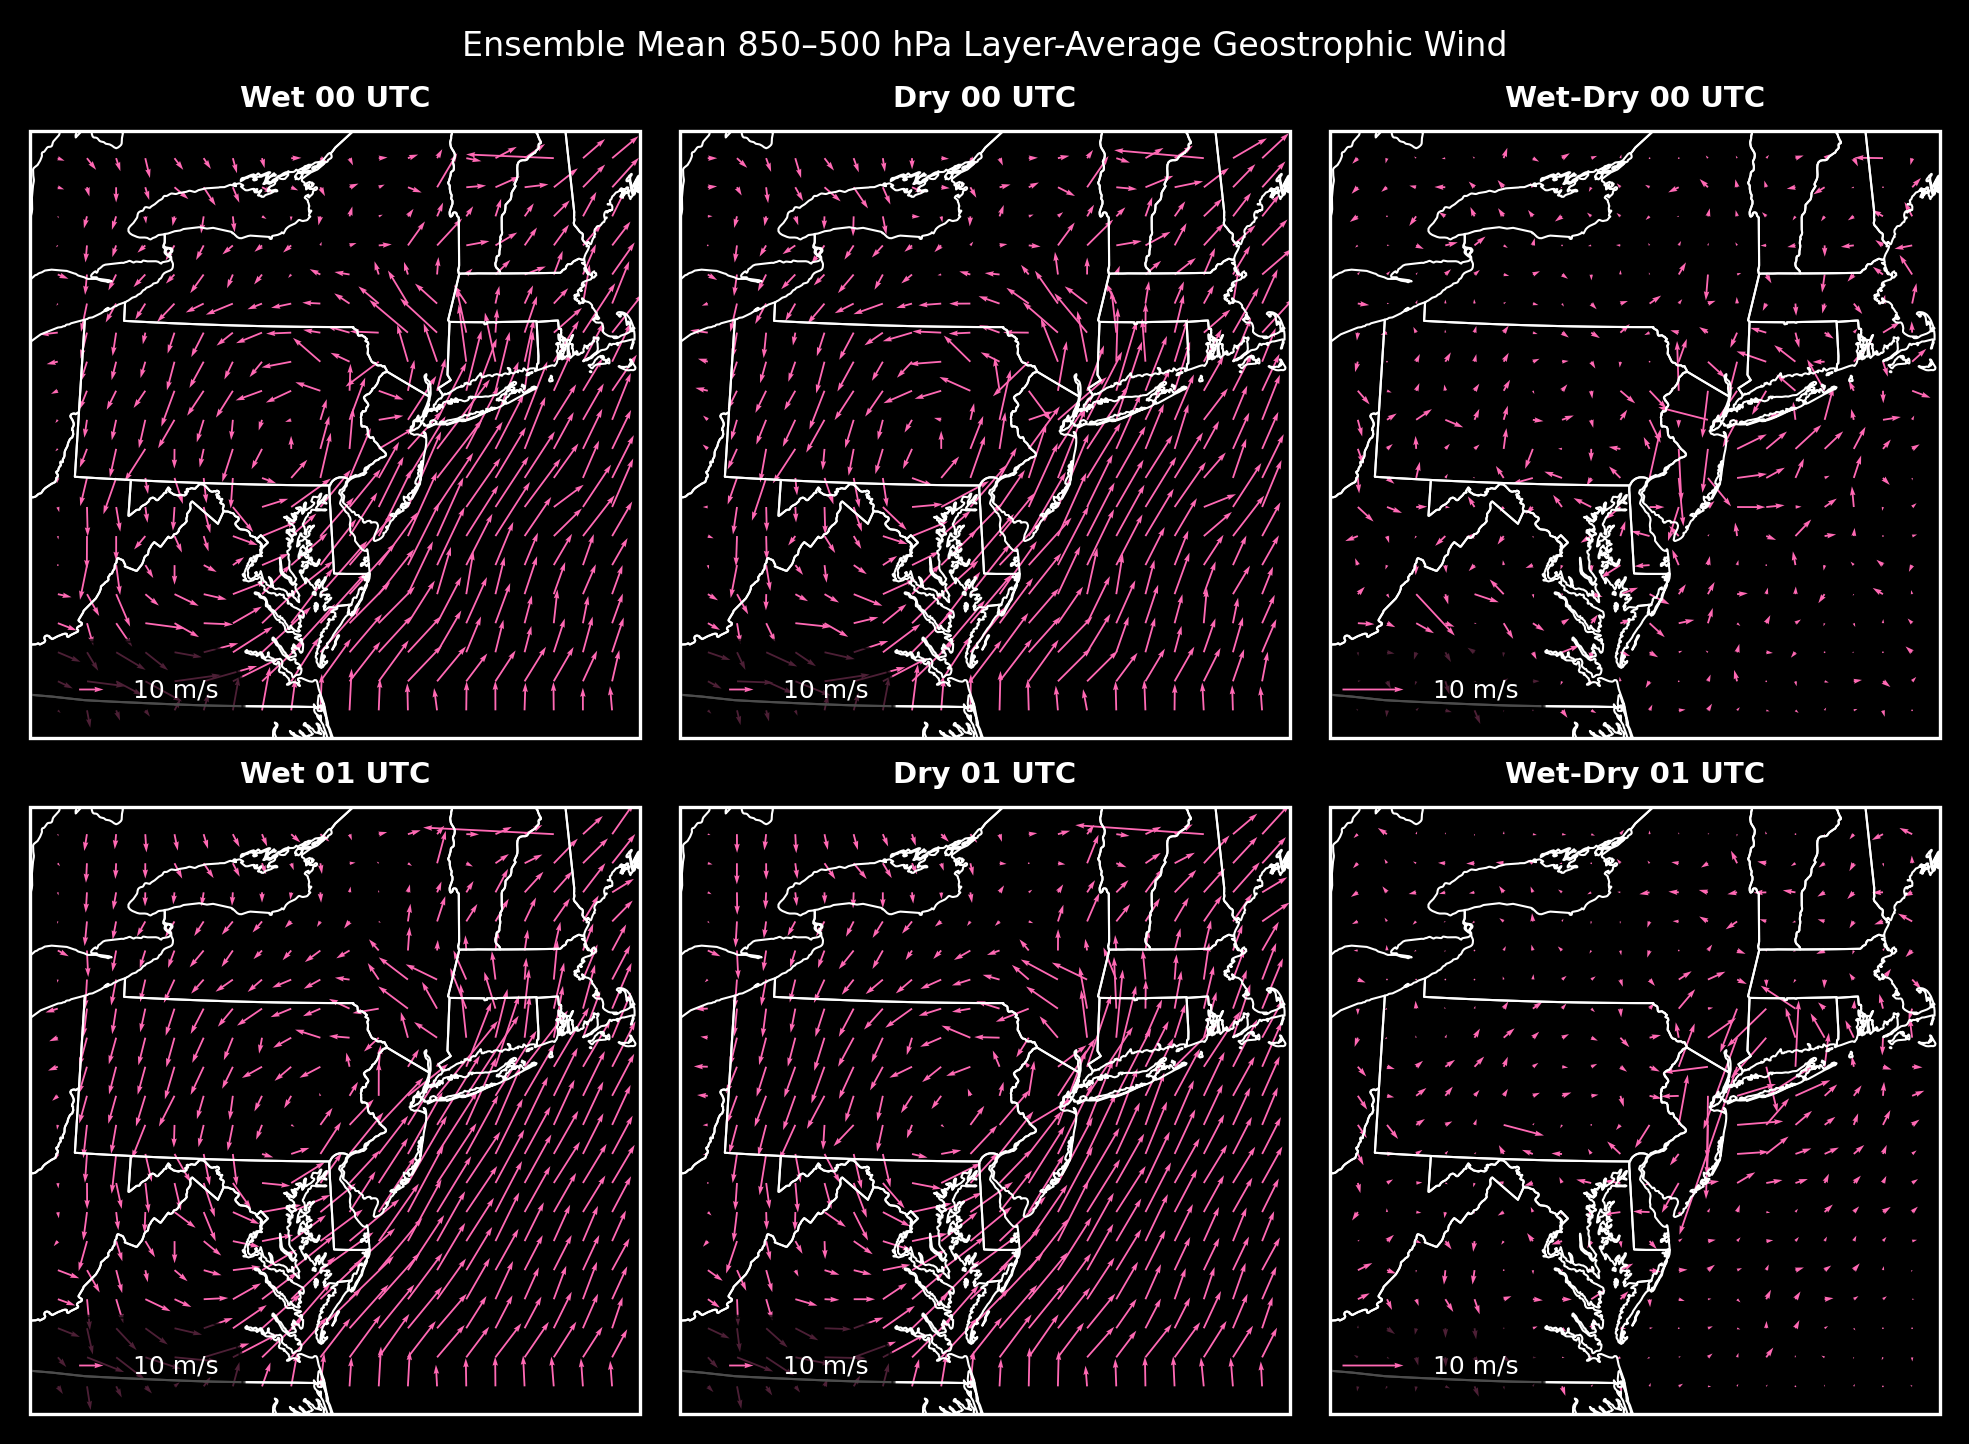

In [99]:
# Titles
titles = ["Wet 00 UTC","Dry 00 UTC","Wet-Dry 00 UTC",
          "Wet 01 UTC","Dry 01 UTC","Wet-Dry 01 UTC"]

# Take every 10th lat and lon values
lon_quiv = lon.values[::15,::15]
lat_quiv = lat.values[::15,::15]
scales = [250,250,100,250,250,100]

# Isolate geostrophic wind vectors, taking every 10th
geo_winds = [
    [
        ug_avg_wet.isel(time=0).squeeze().values[::15, ::15],
        vg_avg_wet.isel(time=0).squeeze().values[::15, ::15],
    ],
    [
        ug_avg_dry.isel(time=0).squeeze().values[::15, ::15],
        vg_avg_dry.isel(time=0).squeeze().values[::15, ::15],
    ],
    [
        ug_avg_diff.isel(time=0).squeeze().values[::15, ::15],
        vg_avg_diff.isel(time=0).squeeze().values[::15, ::15],
    ],
    [
        ug_avg_wet.isel(time=1).squeeze().values[::15, ::15],
        vg_avg_wet.isel(time=1).squeeze().values[::15, ::15],
    ],
    [
        ug_avg_dry.isel(time=1).squeeze().values[::15, ::15],
        vg_avg_dry.isel(time=1).squeeze().values[::15, ::15],
    ],
    [
        ug_avg_diff.isel(time=1).squeeze().values[::15, ::15],
        vg_avg_diff.isel(time=1).squeeze().values[::15, ::15],
    ]
]

fig, axes = plt.subplots(
    2,
    3,
    figsize=(6.5, 4.7),
    dpi=300,
    layout="constrained",
    subplot_kw=dict(projection=proj),
)

for i,ax in enumerate(axes.flat): # type: ignore
    q = ax.quiver(
        lon_quiv,
        lat_quiv,
        geo_winds[i][0],
        geo_winds[i][1],
        transform=ccrs.PlateCarree(),
        scale=scales[i],
        color="hotpink",
    )

    # add state boundaries
    ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="white")

    # Add title
    ax.set_title(titles[i],fontsize=7,fontweight="bold")

    # Add a reference vector with a background rectangle
    bbox = patches.FancyBboxPatch((0.1, 0.05), 0.15, 0.01,
                                  boxstyle="round,pad=0.1",
                                  transform=ax.transAxes,
                                  color='black',
                                  alpha=0.7,
                                  zorder=2)
    ax.add_patch(bbox)
    qk = ax.quiverkey(q, 0.12, 0.08, 10, '10 m/s', labelpos='E', coordinates='axes', fontproperties={'size': 6}, color='hotpink')
    qk.set_zorder(3)

# Set suptitle
plt.suptitle("Ensemble Mean 850–500 hPa Layer-Average Geostrophic Wind",fontsize=8)

plt.show()

## MLCAPE

In [ ]:
mlcape_all = (
    xr.concat([w.cape_ml for w in wofs_all], dim=init)
    .stack(run=("init", "ne"))
    .chunk({"run": -1})
)
mlcape_wet = (
    xr.concat([overwrite_ne(w.cape_ml) for w in wofs_wet], dim=init)  # type: ignore
    .chunk("auto")
    .stack(run=("init", "ne"))
)
mlcape_dry = (
    xr.concat([overwrite_ne(w.cape_ml) for w in wofs_dry], dim=init)  # type: ignore
    .chunk("auto")
    .stack(run=("init", "ne"))
)

In [ ]:
# Time steps to iterate over
times = ["2021-09-02 00:00:00", "2021-09-02 01:00:00"]
results = []

for time in times:
    mlcape_chunked = mlcape_all.sel(time=time).squeeze().chunk({"lat": 25, "lon": 25})
    
    # Resample and compute means
    set1 = resample_iterations_idx(
        mlcape_chunked,
        1000,
        dim="run",
        replace=False,
        dim_max=25,
    ).mean(dim="run")

    set2 = resample_iterations_idx(
        mlcape_chunked,
        1000,
        dim="run",
        replace=False,
        dim_max=25,
    ).mean(dim="run")

    # Compute the difference and quantiles
    with ProgressBar():
        result = (set1 - set2).quantile([0.05, 0.95], dim="iteration").compute()
        results.append(result)

# Combine results along the new time dimension
results = xr.concat(results, dim="time")

[########################################] | 100% Completed | 50.15 s
[########################################] | 100% Completed | 49.85 s


In [ ]:
with ProgressBar():
    mlcape_wet = (
        xr.concat([mlcape_wet.sel(time=t).squeeze() for t in times], dim="time")
        .mean(dim="run")
        .compute()
    )
    mlcape_dry = (
        xr.concat([mlcape_dry.sel(time=t).squeeze() for t in times], dim="time")
        .mean(dim="run")
        .compute()
    )
diff = mlcape_wet - mlcape_dry
mask = (diff < results.sel(quantile=0.05).squeeze()) | (  # type: ignore
    diff > results.sel(quantile=0.95).squeeze()  # type: ignore
)

[########################################] | 100% Completed | 9.73 sms
[########################################] | 100% Completed | 1.74 sms


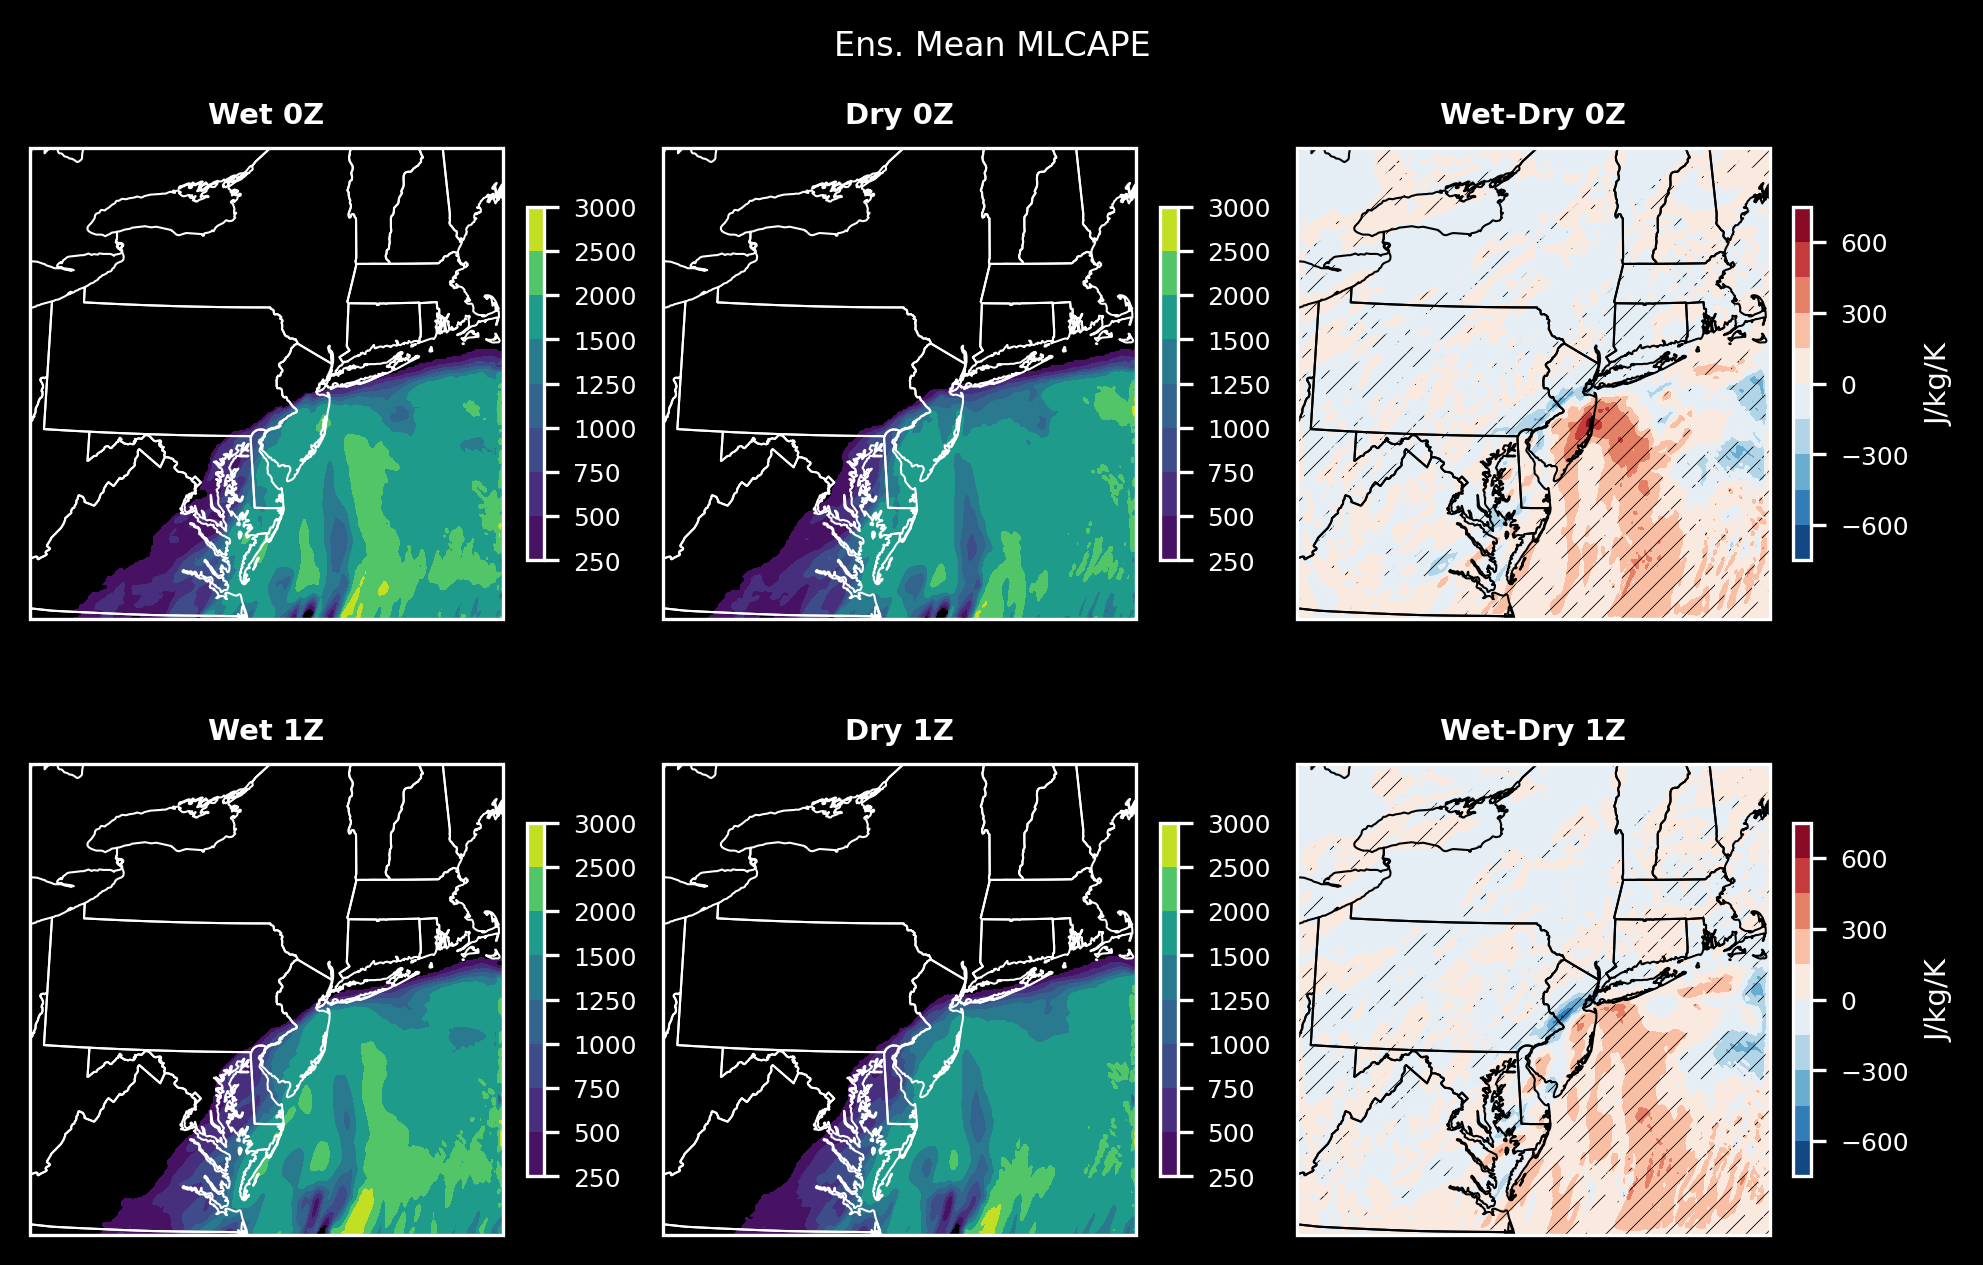

In [ ]:
# Plot pw_hourly_wet, dry, and diff
titles = ["Wet 0Z", "Dry 0Z", "Wet-Dry 0Z",
          "Wet 1Z", "Dry 1Z", "Wet-Dry 1Z"]

cape_levels = [250,500,750,1000,1250,1500,2000,2500,3000]

values = list(
    chain.from_iterable(
        [
            [mlcape_wet.sel(time=t), mlcape_dry.sel(time=t), diff.sel(time=t)]
            for t in times
        ]
    )
)

fig, axes = plt.subplots(
    2,
    3,
    subplot_kw=dict(projection=proj),
    dpi=300,
    layout="constrained",
    figsize=(6.5, 4.3),
)

for i, ax in enumerate(axes.flatten()):
    if i not in [2, 5]:
        c = ax.contourf(
            lon,
            lat,
            values[i].where(values[i]>250).squeeze(),
            transform=ccrs.PlateCarree(),
            levels=cape_levels,
        )
        c.axes.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="white")
    else:
        c = ax.contourf(
            lon,
            lat,
            values[i].squeeze(),
            transform=ccrs.PlateCarree(),
            levels=np.arange(-750,751,150),
            cmap="RdBu_r",
        )
        # Add hatches in masked area
        ax.contourf(
            lon,
            lat,
            mask.sel(time=values[i].time).squeeze(),
            transform=ccrs.PlateCarree(),
            levels=[0, 0.5, 1],
            hatches=["", "/////"],
            colors="none",
        )
        c.axes.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="black")

    cbar = plt.colorbar(c,ax=ax,shrink=0.6)
    cbar.ax.tick_params(labelsize=6)
    if(i in [2,5]):
        cbar.set_label("J/kg/K",fontsize=7)

    ax.set_title(titles[i],fontsize=7, fontweight="bold")

plt.suptitle("Ens. Mean MLCAPE",fontsize=8)
plt.show()

In [21]:
for n in ne_dry:
    print(n.load())

<xarray.DataArray 'ne' (ne: 5)> Size: 40B
array([ 9., 12., 13., 15., 16.])
Dimensions without coordinates: ne
<xarray.DataArray 'ne' (ne: 5)> Size: 40B
array([ 0., 12., 15., 16., 17.])
Dimensions without coordinates: ne
<xarray.DataArray 'ne' (ne: 5)> Size: 40B
array([ 0.,  5., 12., 13., 16.])
Dimensions without coordinates: ne
<xarray.DataArray 'ne' (ne: 5)> Size: 40B
array([ 0.,  5.,  9., 11., 12.])
Dimensions without coordinates: ne
<xarray.DataArray 'ne' (ne: 5)> Size: 40B
array([ 5.,  6.,  9., 13., 15.])
Dimensions without coordinates: ne


## PMM functions

In [102]:
def process_dim(da: xr.DataArray) -> xr.DataArray:
    """Helper function to process DataArray with or without time dimension"""
    ens_mean = da.mean(dim="run").stack(i=("lat", "lon"))
    sorted_mean = ens_mean.sortby(ens_mean)
    sorted_all = np.sort(da.values.flatten())[:: len(da.run)]
    sorted_mean.values = sorted_all
    return sorted_mean.unstack("i")


def pmm(da: xr.DataArray) -> xr.DataArray:
    """Compute the probability matched mean of a DataArray"""
    if "time" in da.dims:
        results = []
        for time_slice in da.time:
            time_da = da.sel(time=time_slice)
            results.append(process_dim(time_da))
        return xr.concat(results, dim="time")
    else:
        return process_dim(da)


@delayed
def bootstrap_iteration(da: xr.DataArray, sample_size: int) -> xr.DataArray:
    """Single iteration of bootstrapping"""
    # Sample without replacement
    sample1 = da.sel(run=np.random.choice(da.run, sample_size, replace=False))
    sample2 = da.sel(run=np.random.choice(da.run, sample_size, replace=False))

    # Compute PMM for each sample
    pmm1 = pmm(sample1)
    pmm2 = pmm(sample2)

    # Compute difference of PMMs
    diff = pmm1 - pmm2
    return diff


def bootstrap_pmm_difference(
    da: xr.DataArray, sample_size: int, iterations: int
) -> xr.DataArray:
    """Perform bootstrapping and compute differences of PMM"""
    tasks = [bootstrap_iteration(da, sample_size) for _ in range(iterations)]
    results = compute(*tasks)
    return xr.concat(results, dim="iteration")

### Rain (and UH)

In [114]:
rain_0102_all = (
    xr.concat([w.rain for w in wofs_all], dim=init)
    .sel(time=slice("2021-09-02 01:05:00", "2021-09-02 02:00:00"))
    .sum(dim="time")
    .stack(run=("init", "ne"))
    .chunk({"run":-1})
)
rain_0102_wet = (
    xr.concat([overwrite_ne(w.rain) for w in wofs_wet], dim=init) # type:ignore
    .sel(time=slice("2021-09-02 01:05:00", "2021-09-02 02:00:00"))
    .sum(dim="time")
    .chunk("auto")
    .stack(run=("init","ne"))
)
rain_0102_dry = (
    xr.concat([overwrite_ne(w.rain) for w in wofs_dry], dim=init) # type: ignore
    .sel(time=slice("2021-09-02 01:05:00", "2021-09-02 02:00:00"))
    .sum(dim="time")
    .chunk("auto")
    .stack(run=("init","ne"))
)

In [115]:
uh_0102_all = (
    xr.concat([w.uh_0to2 for w in wofs_all], dim=init)
    .sel(time=slice("2021-09-02 01:05:00", "2021-09-02 02:00:00"))
    .max(dim="time")
    .stack(run=("init", "ne"))
    .chunk({"run":-1})
)
uh_0102_wet = (
    xr.concat([overwrite_ne(w.uh_0to2) for w in wofs_wet], dim=init) # type:ignore
    .sel(time=slice("2021-09-02 01:05:00", "2021-09-02 02:00:00"))
    .max(dim="time")
    .chunk("auto")
    .stack(run=("init","ne"))
)
uh_0102_dry = (
    xr.concat([overwrite_ne(w.uh_0to2) for w in wofs_dry], dim=init) # type: ignore
    .sel(time=slice("2021-09-02 01:05:00", "2021-09-02 02:00:00"))
    .max(dim="time")
    .chunk("auto")
    .stack(run=("init","ne"))
)

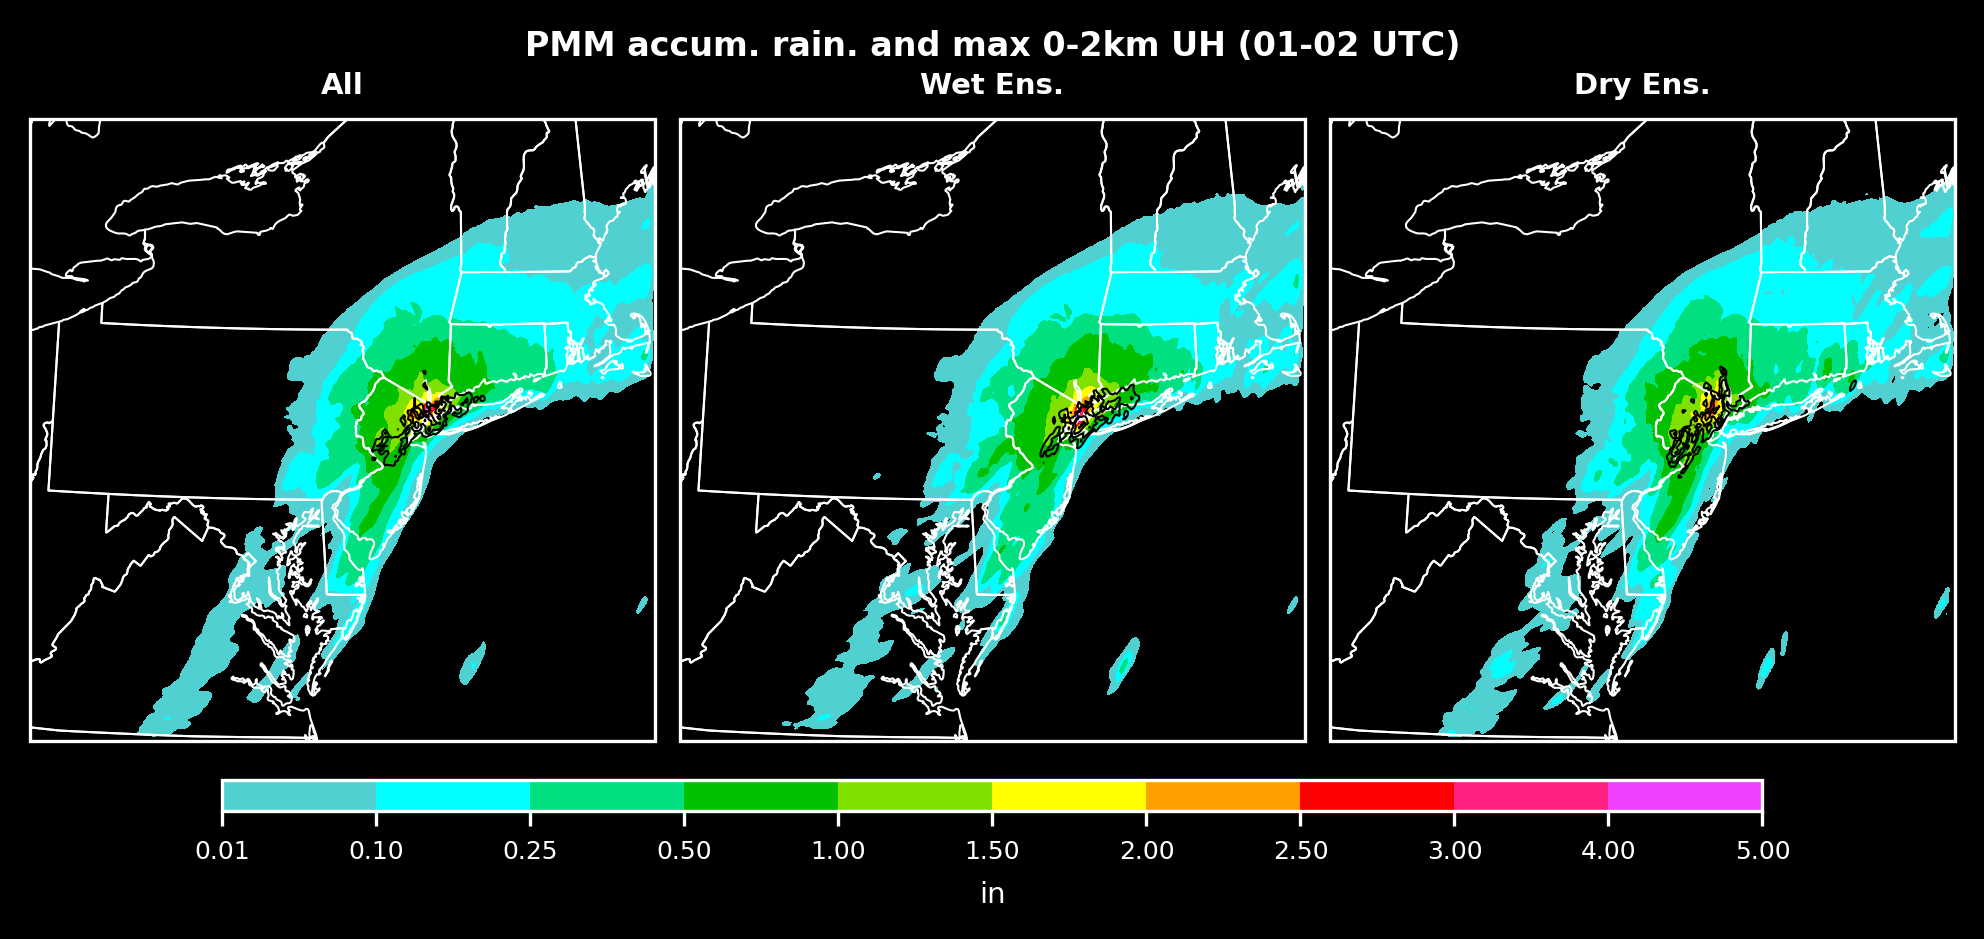

In [116]:
# Make plots of the pmm_rain with pmm_uh_max contoured over it
rain_values = [pmm(r).load() for r in [rain_0102_all,rain_0102_wet,rain_0102_dry]]
uh_values = [pmm(u).load() for u in [uh_0102_all, uh_0102_wet, uh_0102_dry]]
titles = ["All", "Wet Ens.", "Dry Ens."]
levels = [0.01, 0.1, 0.25, 0.50, 1, 1.5, 2, 2.5, 3, 4, 5]

fig, axes = plt.subplots(
    1,
    3,
    figsize=(6.5, 3),
    dpi=300,
    subplot_kw=dict(projection=proj),
    layout="constrained",
)

for i, ax in enumerate(axes.flatten()): #type: ignore
    p = ax.contourf(
        lon,
        lat,
        rain_values[i],
        colors=precip_cmap.colors[1:12], #type: ignore
        levels=levels,
        transform=ccrs.PlateCarree(),
    )

    # Add state boundaries
    ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="white")

    # Contour uh
    c = ax.contour(
    lon,
    lat,
    uh_values[i],
    colors="black",
    levels=[5,10,20,40],
    linewidths=0.5,
    transform=ccrs.PlateCarree(),
    )

    ax.set_title(titles[i], fontsize=7, fontweight="bold")

# Add colorbar
cbar = fig.colorbar(p,ax=axes,shrink=0.8,aspect=50, orientation= "horizontal",)
cbar.ax.tick_params(labelsize=6)
cbar.set_label("in",fontsize=7)
cbar.set_ticks(levels)

plt.suptitle("PMM accum. rain. and max 0-2km UH (01-02 UTC)", fontsize=8,
              fontweight="bold")

plt.show()

In [117]:
diff = pmm(rain_0102_wet) - pmm(rain_0102_dry)

quantiles = (
    bootstrap_pmm_difference(rain_0102_all, sample_size=25, iterations=1000)
    .quantile([0.05, 0.95], dim="iteration")
    .compute()
)

mask = (diff < quantiles.sel(quantile=0.05).squeeze()) | (  # type: ignore
    diff > quantiles.sel(quantile=0.95).squeeze()  # type: ignore
)

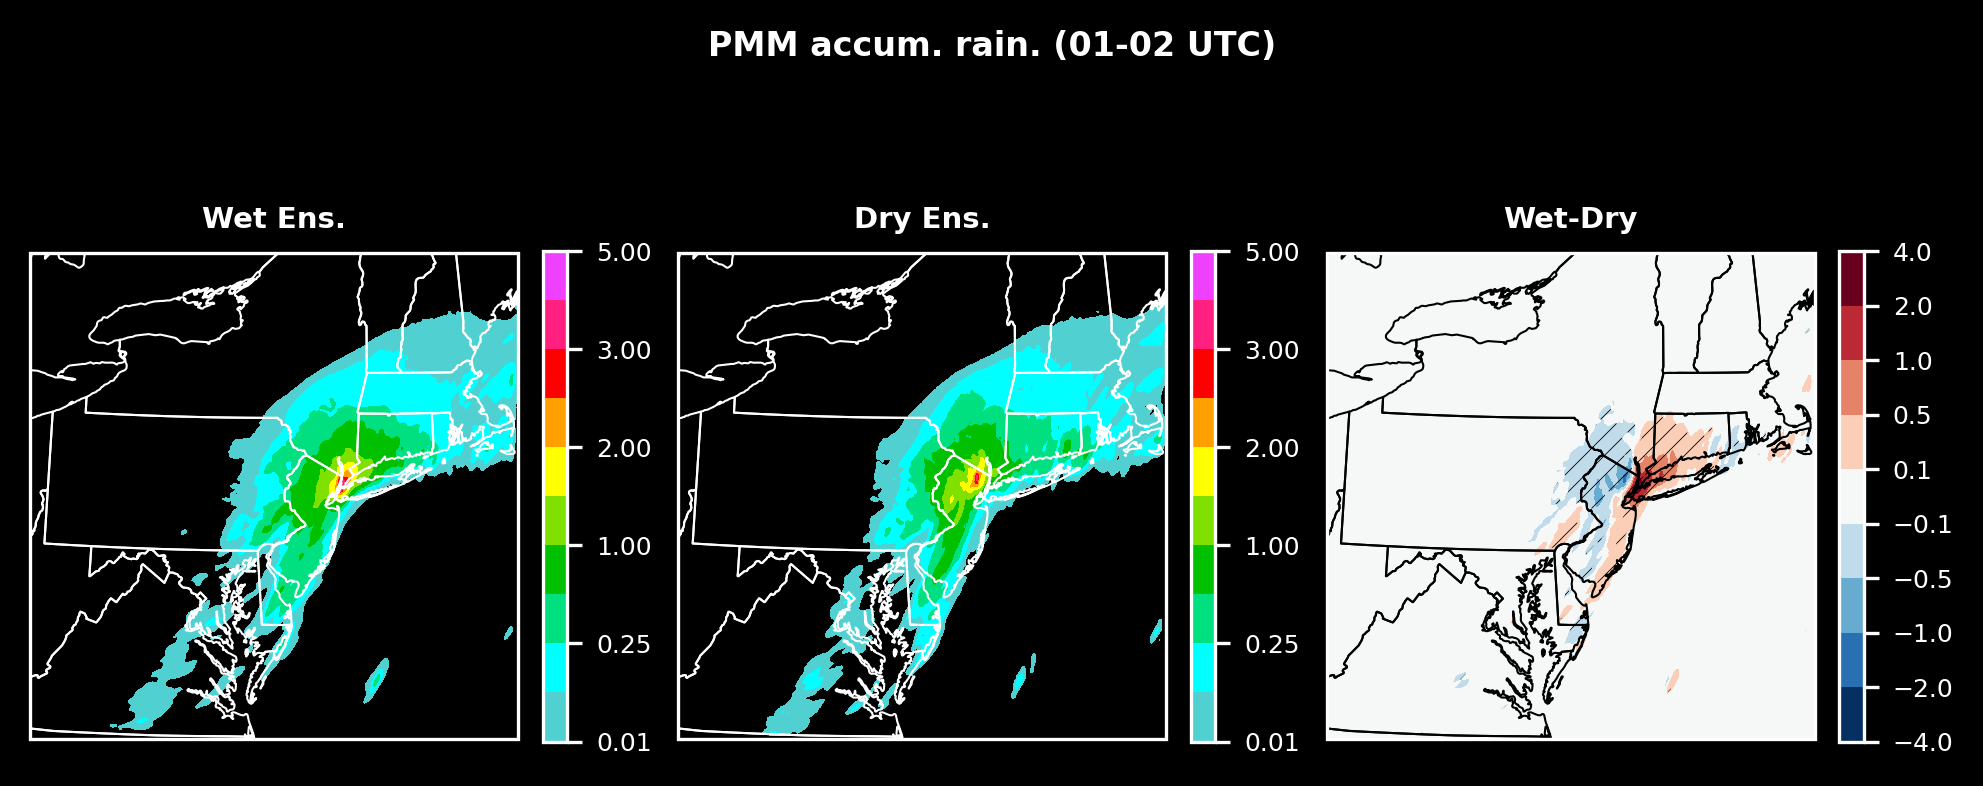

In [126]:
rain_values = [r.load() for r in [pmm(rain_0102_wet), pmm(rain_0102_dry), diff]]
titles = ["Wet Ens.", "Dry Ens.", "Wet-Dry"]
levels = [0.01, 0.1, 0.25, 0.50, 1, 1.5, 2, 2.5, 3, 4, 5]

fig, axes = plt.subplots(
    1,
    3,
    figsize=(6.5, 2.167),
    dpi=300,
    subplot_kw=dict(projection=proj),
    layout="constrained",
)

# Define colormap and normalization for the third panel
cmap = plt.get_cmap("RdBu_r")
norm = BoundaryNorm([-4, -2, -1, -0.5, -0.1, 0.1, 0.5, 1, 2, 4], ncolors=cmap.N, clip=True)

for i, ax in enumerate(axes.flatten()):
    if i != 2:
        c = ax.contourf(
            lon,
            lat,
            rain_values[i],
            colors=precip_cmap.colors[1:12],
            levels=levels,
            transform=ccrs.PlateCarree(),
        )
        ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="white")
    else:
        c = ax.contourf(
            lon,
            lat,
            rain_values[i],
            transform=ccrs.PlateCarree(),
            levels=[-4, -2, -1, -0.5, -0.1, 0.1, 0.5, 1, 2, 4],
            cmap=cmap,
            norm=norm,
        )
        ax.contourf(
            lon,
            lat,
            mask.where(abs(rain_values[i]) > 0.1),
            transform=ccrs.PlateCarree(),
            levels=[0, 0.5, 1],
            hatches=["", "/////"],
            colors="none",
        )
        ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="black")

    cbar = plt.colorbar(c, ax=ax, shrink=0.6)
    cbar.ax.tick_params(labelsize=6)
    ax.set_title(titles[i], fontsize=7, fontweight="bold")

plt.suptitle("PMM accum. rain. (01-02 UTC)", fontsize=8, fontweight="bold")
plt.show()


### Reflectivity

In [129]:
dbz_all = (
    xr.concat([w.comp_dz for w in wofs_all], dim=init)
    .sel(time=slice("2021-09-02 00:00:00", "2021-09-02 02:00:00"))
    .stack(run=("init", "ne"))
    .chunk({"run": -1})
)[::6]
dbz_wet = (
    xr.concat([overwrite_ne(w.comp_dz) for w in wofs_wet], dim=init) # type: ignore
    .sel(time=slice("2021-09-02 00:00:00", "2021-09-02 02:00:00"))
    .chunk("auto")
    .stack(run=("init", "ne"))
)[::6]
dbz_dry = (
    xr.concat([overwrite_ne(w.comp_dz) for w in wofs_dry], dim=init) # type: ignore
    .sel(time=slice("2021-09-02 00:00:00", "2021-09-02 02:00:00"))
    .chunk("auto")
    .stack(run=("init", "ne"))
)[::6]

In [130]:
diff = pmm(dbz_wet) - pmm(dbz_dry)

quantiles = (
    bootstrap_pmm_difference(dbz_all, sample_size=25, iterations=1000)
    .quantile([0.05, 0.95], dim="iteration")
)

mask = (diff < quantiles.sel(quantile=0.05).squeeze()) | (  # type: ignore
    diff > quantiles.sel(quantile=0.95).squeeze()  # type: ignore
)

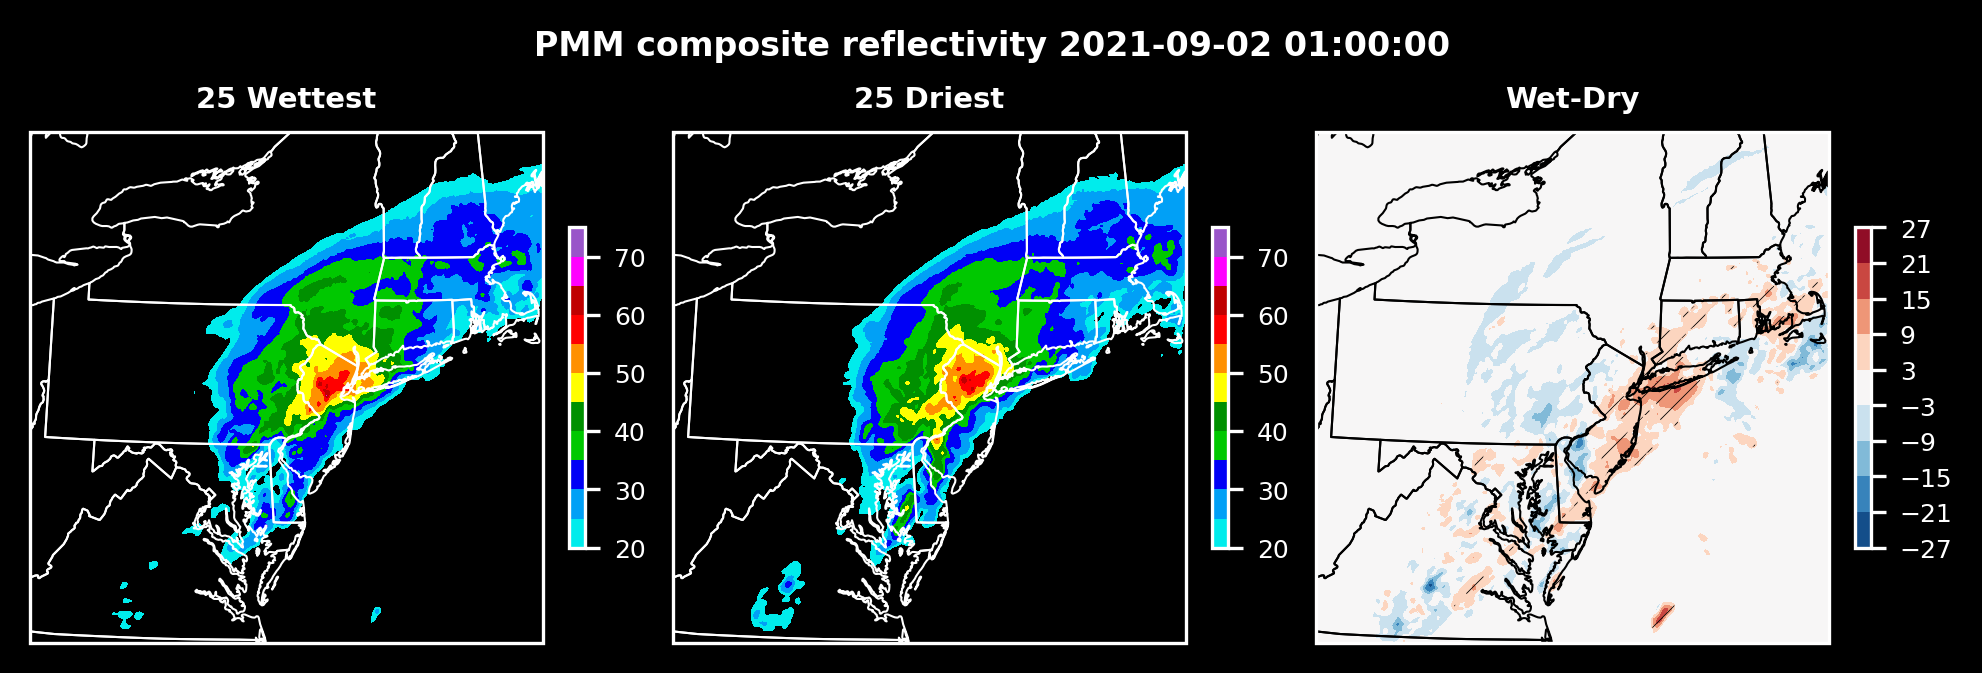

In [12]:
# Make plots of the pmm_rain with pmm_uh_max contoured over it
values = [d.sel(time="2021-09-02 00:00:00").squeeze().load() for d in [pmm(dbz_wet),pmm(dbz_dry), diff]]
mask_current = mask.sel(time="2021-09-02 00:00:00").squeeze().load()
titles = ["25 Wettest", "25 Driest", "Wet-Dry"]
levels = range(20,76,5)

fig, axes = plt.subplots(
    1,
    3,
    figsize=(6.5, 2.167),
    dpi=300,
    subplot_kw=dict(projection=proj),
    layout="constrained",
)

for i, ax in enumerate(axes.flatten()): #type: ignore
    if i not in [2]:
        c = ax.contourf(
            lon,
            lat,
            values[i],
            colors=refl_cmap(np.linspace(0,0.92,11)), #type: ignore
            levels=levels,
            transform=ccrs.PlateCarree(),
        )

        # Add state boundaries
        ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="white")

    else:
        c = ax.contourf(
            lon,
            lat,
            values[i],
            transform=ccrs.PlateCarree(),
            levels=range(-27,28,6),
            cmap="RdBu_r",
        )
        # Add hatches in masked area
        ax.contourf(
            lon,
            lat,
            mask_current.where(abs(values[i]>3)),
            transform=ccrs.PlateCarree(),
            levels=[0, 0.5, 1],
            hatches=["", "/////"],
            colors="none",
        )
        c.axes.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="black")

    # Add colorbar
    cbar = plt.colorbar(c,ax=ax,shrink=0.6)
    cbar.ax.tick_params(labelsize=6)

    ax.set_title(titles[i], fontsize=7, fontweight="bold")

plt.suptitle("PMM composite reflectivity 2021-09-02 01:00:00", fontsize=8,
              fontweight="bold")

plt.show()

MovieWriter Pillow unavailable; using Pillow instead.


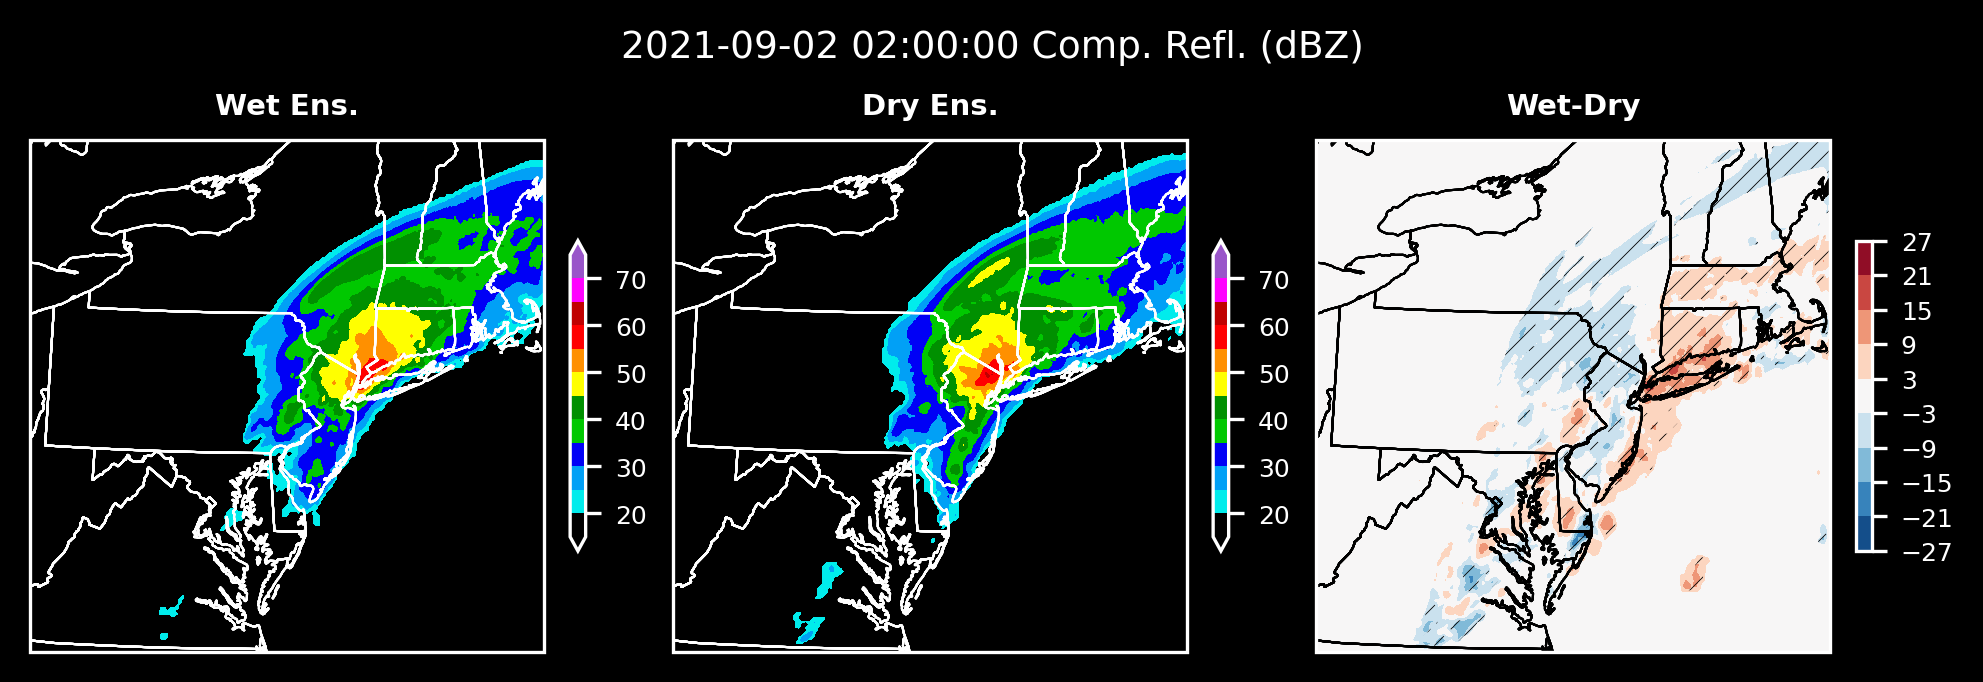

In [133]:
# Load data
values = [d.load() for d in [pmm(dbz_wet), pmm(dbz_dry), diff]]
mask_current = mask.load()
titles = ["Wet Ens.", "Dry Ens.", "Wet-Dry"]
levels = range(20, 76, 5)

fig, axes = plt.subplots(
    1,
    3,
    figsize=(6.5, 2.167),
    dpi=300,
    subplot_kw=dict(projection=proj),
    layout="constrained",
)

# Function to update each frame
def update(frame):
    for i, ax in enumerate(axes.flatten()):  # type: ignore
        if i not in [2]:
            data = values[i].sel(time=frame).squeeze()
            data = np.ma.masked_less(data, 20)  # Mask values less than 20
            # Create a copy and set masked values to black (use -999 for masked values)
            plot_data = data.filled(-999)
            c = ax.contourf(
                lon,
                lat,
                plot_data,
                colors=['black'] + list(refl_cmap(np.linspace(0, 0.92, 11))),  # Add black to the colormap
                levels=[-100] + list(levels),  # Add a level for black
                transform=ccrs.PlateCarree(),
                extend='both'
            )
            # Add state boundaries
            ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="white")
        else:
            data = values[i].sel(time=frame).squeeze()
            c = ax.contourf(
                lon,
                lat,
                data,
                transform=ccrs.PlateCarree(),
                levels=range(-27, 28, 6),
                cmap="RdBu_r",
            )
            # Add hatches in masked area
            ax.contourf(
                lon,
                lat,
                mask_current.sel(time=frame).where(abs(data) > 3).squeeze(),
                transform=ccrs.PlateCarree(),
                levels=[0, 0.5, 1],
                hatches=["", "/////"],
                colors="none",
            )
            c.axes.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="black")

        ax.set_title(titles[i], fontsize=7, fontweight="bold")

        # Remove previous colorbar if exists
        if hasattr(ax, 'colorbar'):
            ax.colorbar.remove()

        # Add colorbar
        cbar = fig.colorbar(c, ax=ax, shrink=0.6)
        cbar.ax.tick_params(labelsize=6)
        ax.colorbar = cbar

    # Make suptitle containing time value and stating reflectivity
    fig.suptitle(
        str(frame) + " Comp. Refl. (dBZ)",
        fontsize=9,
    )

# Define times for animation
times = ["2021-09-02 00:00:00", "2021-09-02 00:30:00", "2021-09-02 01:00:00", "2021-09-02 01:30:00", "2021-09-02 02:00:00"]

# Create animation
anim = FuncAnimation(fig, update, frames=times, repeat=True)

# Save the animation
anim.save("comp_refl.gif", writer="Pillow", fps=2)

# Show the plot
plt.show()